In [2]:
import numpy as np
from pathlib import Path
from utils import project_root
from scipy.spatial.transform import Rotation
import numpy as np
import os
import pymap3d as pm
from random import randrange
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib notebook
plt.rcParams["figure.figsize"] = (8,8)

# Globals

In [3]:
# GLOBAL VARIABLES
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]
# rotation from base_link to IMU
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
# radar translational offset
radar_off = np.array([0.915, 0, 0.895]).reshape((3,1))
# gravity
GRAV = 9.80665

# define covariances
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]
# extract variances and std. deviations
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)
# we manual tune the radar std. deviation and variance
sigma_r = 0.1
var_r = sigma_r**2

# rotation order
rot_order = 'xyz'

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# Helpers

In [4]:
# rotation order
rot_order = 'xyz'

# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

# convert euler to quaternion
def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

# get rotation matrix from euler angles
def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# extract euler angles from rotation matrix
def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Preprocess

In [5]:
# load GPS data
def LoadGPS():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('gps.txt') as f:
        lines = f.readlines()

        lattitude = []
        longitude = []
        altitude = []
        sec_gps = []
        nsec_gps = []
        count = 0
        for line in lines:
            count += 1
            if line[4:7] == "sec":
                sec_gps.append(int(line[9:-1]))
            elif line[4:11] == "nanosec":
                nsec_gps.append(int(line[13:-1]))
            elif line[0:3] == "lat":
                lattitude.append(float(line[10:-1]))
            elif line[0:3] == "lon":
                longitude.append(float(line[11:-1]))
            elif line[0:3] == "alt":
                altitude.append(float(line[10:-1]))

    temp = [i*1e-9 for i in nsec_gps]
    t_gps = [sum(x) for x in zip(sec_gps, temp)]
    tt_gps = np.array([x-t_gps[0] for x in t_gps])

    # convert lat,long,alt to x,y,z
    lat_0 = lattitude[0]
    lon_0 = longitude[0]
    alt_0 = altitude[0]

    x_gps = []
    y_gps = []
    z_gps = []
    for i in range(len(lattitude)):
        # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
        x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
        # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
        x_gps.append(x_ + gps_off[0])
        y_gps.append(y_ + gps_off[1])
        z_gps.append(z_ + gps_off[2])

    x_gps = np.array(x_gps)
    y_gps = np.array(y_gps)
    z_gps = np.array(z_gps)

    # extract linear velocities from differentiating gps positions
    vx_gps = []
    vy_gps = []
    vz_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            vx, vy, vz = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
            vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
            vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
            
        vx_gps.append(vx)
        vy_gps.append(vy)
        vz_gps.append(vz)

    vx_gps = np.array(vx_gps)
    vy_gps = np.array(vy_gps)
    vz_gps = np.array(vz_gps)

    # extract linear accelerations from double differentation of gps positions
    ax_gps = []
    ay_gps = []
    az_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            ax, ay, az = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
            ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
            az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
            
        ax_gps.append(ax)
        ay_gps.append(ay)
        az_gps.append(az)

    ax_gps = np.array(ax_gps)
    ay_gps = np.array(ay_gps)
    az_gps = np.array(az_gps)

    # extract GPS bias from the first 3 seconds of the video, where the vehicle is static
    gps_bias = np.array([np.mean(x_gps[0:30]), np.mean(y_gps[0:30]), np.mean(z_gps[0:30])])

    # combine position, velocity and acceleration data into single arrays
    p_gps = np.hstack((x_gps, y_gps, z_gps))
    v_gps = np.hstack((vx_gps.reshape((-1,1)), vy_gps.reshape((-1,1)), vz_gps.reshape((-1,1))))
    a_gps = np.hstack((ax_gps.reshape((-1,1)), ay_gps.reshape((-1,1)), az_gps.reshape((-1,1))))

    return tt_gps, p_gps, v_gps, a_gps, gps_bias

# load IMU data
def LoadIMU():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('imu.txt') as f:
        lines = f.readlines()

    ang_vel = [] # [w_x, w_y, w_z]
    ang_vel_e = []
    lin_acc = [] # [x_ddot, y_ddot, z_ddot]
    sec_imu = []
    nsec_imu = []
    count = 0

    for idx, line in enumerate(lines):
        count += 1
        if line[4:7] == "sec":
            sec_imu.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_imu.append(int(line[13:-1]))
        elif line[0:-1] == "orientation:":
            qx = float(lines[idx+1][5:-1])
            qy = float(lines[idx+2][5:-1])
            qz = float(lines[idx+3][5:-1])
            qw = float(lines[idx+4][5:-1])
        elif line[0:-1] == "angular_velocity:":
            w_x = float(lines[idx+1][5:-1])
            w_y = float(lines[idx+2][5:-1])
            w_z = float(lines[idx+3][5:-1])
            ang_vel.append([w_x, w_y, w_z])
            ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
        elif line[0:-1] == "linear_acceleration:":
            a_x = float(lines[idx+1][5:-1])
            a_y = float(lines[idx+2][5:-1])
            a_z = float(lines[idx+3][5:-1])
            lin_acc.append([a_x, a_y, a_z])

    ang_vel = np.array(ang_vel)
    ang_vel_e = np.array(ang_vel_e)
    lin_acc = np.array(lin_acc)

    temp = [i*1e-9 for i in nsec_imu]
    t_imu = [sum(x) for x in zip(sec_imu, temp)]
    tt_imu = [x-t_imu[0] for x in t_imu]

    # extract the IMU bias from the first 3 seconds, when the vehicle is not moving
    static_ang_vel = np.array(ang_vel)[0:300,:]
    ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
    static_lin_acc = np.array(lin_acc)[0:300,:]
    lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
    lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias

    # extract oriantation for the entire dataset based on IMU readings
    theta0_z = 0.16 # TUNE THIS
    q_imu_list = np.empty((0,4), float)
    q_prev = euler2quat(np.array([0, 0, theta0_z]))
    for i in range(len(tt_imu)):
        # in the first iteration, set theta = 0
        if i==0:
            q_next = euler2quat(np.array([0, 0, theta0_z]))
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_imu[i] - tt_imu[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")
            
            # find the current robot rotation matrix
            R_robot = quat2matrix(q_prev)
            R = R_b2i.T@R_robot
            
            # new orientation based on quaternion kinematics       
            w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
            w_norm = np.linalg.norm(w_theta)
            q_w = np.cos(w_norm/2)
            q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
            q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
            
            q_next = quat_mult(q_prev, q2)
            r_next = quat2euler(q_next, "xyz")
                
        q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
            
        q_prev = q_next
        
    theta_imu_list = np.empty((0,3), float)
    for x in q_imu_list:
        th = quat2euler(x)
        theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

    return tt_imu, lin_acc, ang_vel, theta_imu_list, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias

# load radar data
def LoadRadar():
    # load ROS data from txt file - azimuth and speed_radial readings from the ros2 bag "2021_10_26-16_14_27"
    os.chdir(Path(project_root() / 'data/radar_pointclouds/raw'))

    lines = []
    with open('2022-02-17.txt') as f:
        lines = f.readlines()

    # these lists will keep all the returns from the entire video
    theta_list = []
    v_r_list = []
    r_list = []

    # these lists will keep the returns just for one frame of the video
    sec_list = []
    nsec_list = []
    theta = [] # azimuth angle in !radians!
    v_r = [] # radial speed
    r = [] # range

    # iterate over the entire video
    for line in lines:
        # check if we have a new scan
        if line[0:3] == "New":
            # if it is not the first, add the previous scan to the list of all the scans
            if theta and v_r:
                r_list.append(r)
                theta_list.append(theta)
                v_r_list.append(v_r)

            # reset the lists for this current frame
            r = []
            theta = []
            v_r = []

        elif line[0:3] == "Sec":
            sec_list.append(int(line[5:-1]))
        elif line[0:4] == "Nsec":
            nsec_list.append(int(line[6:-1]))
        elif line[0:1] == "r":
            r.append(float(line[2:-1]))
        elif line[0:1] == "a":
            theta.append(np.deg2rad(float(line[2:-1])))
        elif line[0:3] == "v_r":
            v_r.append(float(line[4:-1]))

    # append the last 2 items
    r_list.append(r)
    theta_list.append(theta)
    v_r_list.append(v_r)

    temp = [i*1e-9 for i in nsec_list]
    t_radar = [sum(x) for x in zip(sec_list, temp)]
    tt_radar = [x-t_radar[0] for x in t_radar]

    return tt_radar, r_list, theta_list, v_r_list

# Radar Odom

## Functions

In [6]:
# function to remove all the radar readings with 0 radial speed or radial speed < val
def remove_zero_radial(vr, the, ra, val=0):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if abs(vr[j]) <= val:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# function to remove all the radar readings that have very low range
def remove_low_range(vr, the, ra, range_thresh):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if ra[j] < range_thresh:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# part 1 - Ransac function
def Ransac(theta, v_r, error_threshold, max_iter, stop_e, stop_in, ransac_flag=True, criteria="num_inliers"):    
    num_radar_points = len(theta)
    # check if we do not have enough non-zero radial_speed returns
    # c1_ = np.count_nonzero(v_r) < round(num_radar_points/8)
    c2_ = np.count_nonzero(v_r) < 5 # 5 is chosen arbitrarily
    if c2_:
        return False, [], [], 0, 100, 100, None
        
    i = 0
    max_inliers = 0
    min_e = 9999
    best_inliers = []
    best_outliers = []
    v_s = None
    alpha = None
    cond = False
    
    # if the criteria is error %, we need the sum of all the absolute radial speeds
    sum_vr = 0
    for j in range(num_radar_points):
        sum_vr += abs(v_r[j])
    
    # Ransac loop
    while (True):
        # exit criteria
        if cond or i>=max_iter:
            break
        
        # check if we will use 2 points or a subsample during ransac
        if (not ransac_flag):
            # generate random number between 0 and *# of radar points*-1
            p1 = randrange(num_radar_points)
            p2 = randrange(num_radar_points)
            while (p2==p1):
                p2 = randrange(num_radar_points)

            # Analytical approach (solving the 2x2 system)
            num = (np.cos(theta[p1])*v_r[p2]) - (np.cos(theta[p2])*v_r[p1])
            denom = (np.cos(theta[p1])*np.sin(theta[p2])) - (np.sin(theta[p1])*np.cos(theta[p2]))
            v_y = num/denom
            v_x = ( v_r[p2] - (np.sin(theta[p2])*v_y) ) / np.cos(theta[p2])
        else:
            # generate random subsample of semi-random size m >= 2
            subsample = []
            n_ = 6
            m = round(num_radar_points/n_)
            while m < 2:
                n_ -= 1
                m = round(num_radar_points/n_)
            for j in range(m):
                # generate random indeces in [0, num_radar_points)
                p = randrange(0, num_radar_points)
                # no duplicates!!
                while (p in subsample):
                    p = randrange(0, num_radar_points)
                subsample.append(p)
    
            # initialize matrix A and B for the LSQ problem
            A = []
            b = []

            # iterate over the subsample
            for j in subsample:
                # fill the A and b matrix
                A1 = np.cos(theta[j])
                A2 = np.sin(theta[j])
                A.append([A1, A2])
                b.append(v_r[j])

            # solve LSQ    
            sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
            # x
            v_x = sol[0][0]
            v_y = sol[0][1]
            # sum of squared residuals
            SSR = sol[1]

        # now find the sensor velocity and yaw rate
        if v_x != 0: # avoid division by 0 (non-moving vehicle)
            alpha = np.arctan2(v_y,v_x)
            v_s = -v_x/np.cos(alpha)

            # calculate the error of the current fit and the number of outliers/inliers
            sum_e = 0
            current_inliers = [] # index of all the inlier radar readings
            current_outliers = [] # index of all the outlier radar readings
            for j in range(num_radar_points):
                # measure the error between the radial speed and the sensor velocity
                e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 

                # if the current radar reading has a small error, compared to the velocity profile of 
                # the randomly chosen subsample/2 points, it is an inlier
                if ( e < (error_threshold*abs(v_r[j])) ):
                    current_inliers.append(j)
                else:
                    current_outliers.append(j)
                # count the accumulated error to determine best fit
                sum_e += e

            # keep the best fit in terms of minimum error and maximum inliers (this is the same most of the times)
            if (len(current_inliers) > max_inliers):
                max_inliers = len(current_inliers)
                min_e = sum_e
                # calculate the % of inliers and
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria == "num_inliers":
                    # keep the inliers and outliers
                    best_inliers = current_inliers
                    best_outliers = current_outliers
            if (sum_e < min_e):
                min_e = sum_e
                max_inliers = len(current_inliers)
                # calculate the % of error
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria=="error":
                    best_inliers = current_inliers
                    best_outliers = current_outliers

        i+=1
        
        # determine which is the first condition to break the loop, based on the criteria given
        if criteria=="error":
            cond = min_e < stop_e*sum_vr # the minimum error being less than (stop_e)% of the sum of radial velocities
        else:
            cond = max_inliers > round(stop_in*num_radar_points) # the max inliers being more than (stop_in)% of the points 
            
        # give proper warning if ransac did not converge at max_iter
        if (i == max_iter):
            print(f"Warning! Ransac did not converge but stopped at {max_iter} iterations.")
            
            # depending on criteria, give diagnostic message
            if criteria == "error":
                print(f"Minimum error %: {pct_e}.")
            else:     
                print(f"% of inliers: {pct_inl}.")

    return True, best_inliers, best_outliers, i, pct_e, pct_inl, SSR

# part 2 - LSQ
# perform LSQ to get the sensor velocity and direction based on the inliers from Ransac,  
# the azimuth and the radial_speed radar readings
def inliers_LSQ(best_inliers, theta, v_r, error_threshold):
    # print()"Step 2: LSQ on the inlier set.")
    # initialize the A matrix and b vector for the least squares prloblem
    A = []
    b = []

    # iterate over all the inliers
    for j in best_inliers:
        # fill the A and b matrix
        A1 = np.cos(theta[j])
        A2 = np.sin(theta[j])
        A.append([A1, A2])
        b.append(v_r[j])

    # solve the LSQ problem 
    sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
    # the solution is going to be used to extract the sensor velocity and heading direction
    # v_x and v_y are the radar sensor linear velocities in the x,y directions
    v_x = sol[0][0]
    v_y = sol[0][1]
    # sum of squared residuals
    SSR = sol[1]

    # calculate sensor velocity and direction
    alpha = np.arctan2(v_y,v_x)
    v_s = -v_x/np.cos(alpha)

    # get new, improved inliers
    final_inliers = []
    final_outliers = []
    sum_e = 0
    for j in range(len(v_r)):
        # measure the error between the radial speed and the sensor velocity
        e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 
        sum_e += e

        # if the current radar reading has a small error, it is an inlier
        if (e<error_threshold):
            final_inliers.append(j)
        else:
            final_outliers.append(j)
            
    # determine which is the first condition to break the loop, based on the criteria given
    pct_e = 100*sum_e/sum([abs(_) for _ in v_r])
    pct_inl = 100*len(final_inliers)/len(v_r)
    
    return v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e, pct_inl, SSR

# part 3 - ego-motion estimation
def ego_motion(v_s, alpha, b_, l_, beta_):
    # print()"Step 3: Ego-motion estimation.")
    # if the vehicle is moving, proceed to find the sensor and vehicle velocity and yaw rates
    if (v_s != 0):
        # now calculate the vehicle velocity and yaw rate based on the Ackerman condition
        v = ( np.cos(alpha + beta_) - ((b_/l_)*np.sin(alpha+beta_)) ) * v_s
        omega = (np.sin(alpha+beta_)/l_) * v_s
    else:
        print("\t\t\t WTF!!Non-moving vehicle!!")
        v = 0
        omega = 0
    
    return v, omega

## Loop

In [7]:
# apply radar odometry on the the current radar scan
'''
Returns:

0. retflag : 0 = Not enough non-zero radial_speed returns, 1 = Ransac didn't return enough inliers, 2 = 
1. v : vehicle radial velocity
2. w : vehicle yaw rate
'''
def radar_odometry(t, r_list, theta_list, v_r_list, v_prev):
    # tuning
    # Ransac
    # use sub-samples flag
    ransac_flag = True
    # stoppage criteria
    crit = "num_inliers"
    max_iter = 50 # maximum iterations
    stop_error = 0.05 # total error %
    stop_inl = 0.9 # % of inliers
    # percentage of error allowed to be considered inlier
    error_threshold = 0.1

    # Filtering
    radial_speed_filtering = False
    radial_threshold = 0 # removing all 0 radial speed returns
    range_filtering = False
    range_threshold = 1 # meters
    velocity_filtering = False
    velocity_thresholod = 0.5 # percentage of velocity deviation that is allowed between iterations

    # LSQ criteria
    lsq_inlier_pct_thresh = 0.5 # % of Ransac inliers required to accept LSQ result
    lsq_inlier_num_thresh = 5 # number of Ransac inliers required to accept LSQ result

    # LSQ performance
    ssr_ransac, ssr_lsq = None, None

    # print time and size of radar scan
    print(f"At time: {t} seconds.")
    print(f"# of radar readings: {len(theta_list)}")

    # filter based on radial_speeds returns. There should almost never be 0 radial speeds. If there are, we are probably stationary or sth is wrong
    if radial_speed_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_zero_radial(v_r_list, theta_list, r_list, radial_threshold)
        print(f"# of radar readings after radial speed filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")

    # filter based on range, to avoid objects that are too close to the radar sensor and block the view
    if range_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_low_range(v_r_list, theta_list, r_list, range_threshold)
        print(f"# of radar readings after range filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")
    
    # step 1 - ransac
    # if false, ransac is applied with 2 random pooints, otherwise, it uses a subsample
    # of the total radar_points
    # criteria can either be "error" or "num_inliers"
    print("Step 1. Ransac...")
    retval, inliers, outliers, it, pct_e_ransac, pct_inl_ransac, ssr_ransac = Ransac(theta_list, v_r_list, 
                                                                        error_threshold, max_iter,
                                                                        stop_error, stop_inl,
                                                                        ransac_flag=True, criteria=crit)
    print(f"\t# of inliers: {len(inliers)}")
    print(f"\t# of iterations: {it}")
    print(f"\tSSR: {ssr_ransac}")

    # check if we had enough radial speed returns
    if not retval:
        print(f"Not enough non-zero radial_speed returns ({np.count_nonzero(v_r_list)}) !")
        retflag = 1
        v, omega = 0, 0
    else:
        # check if Ransac gave an adequate amount of inliers
        if len(inliers) < lsq_inlier_pct_thresh*len(theta_list) or len(inliers) < lsq_inlier_num_thresh:
            print("Warning! Not enough inliers!!")
            retflag = 2
            v, omega = None, None
        else:
            retflag = 0
            # step 2 - LSQ
            print("Step 2. LSQ...")
            v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e_lsq, pct_inl_lsq, ssr_lsq = inliers_LSQ(inliers, 
                                                                                                            theta_list, 
                                                                                                            v_r_list, 
                                                                                                            error_threshold)
            print(f"\tLSQ SSR: {ssr_lsq}")
            print(f"\tLSQ # of optimized inliers: {len(final_inliers)}")
            print(f"\tLSQ Error: {pct_e_lsq} %")
            print(f"\tSensor velocity: {v_s} (m/sec)\n\tSensor direction: {alpha} (rad)")

            # step 3 - ego-motion
            l_ = 0.915; # x_s
            b_ = 0; # y_s
            beta_ = 0; # a_s
            print("Step 3. Ego-motion...")
            v, omega = ego_motion(v_s, alpha, b_, l_, beta_)
            print(f"\tVehicle velocity: {v} (m/s)\n\tVehicle yaw rate: {omega} (rad/sec)")

            # reject fits that indicate the problem of the largest group being moving targets (too big velocity deviation from previous reading)
            if velocity_filtering:
                v_diff = abs(v_prev - v)
                if v_diff > abs(velocity_thresholod*v_prev) and v_prev != 0:
                    print(f"Danger!! Large velocity deviation: {v_prev - v} m/sec! Skipping this iteration...")
                    retflag = 3
                    v, omega, ssr_lsq = None, None, None

    return t, v, omega, ssr_ransac, ssr_lsq, retflag

# Sensor Fusion

## Functions

In [8]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    pg_i = x_prev[19:22]
    qg_i = x_prev[22:26]
    pr_i = x_prev[26:29]
    qr_i = x_prev[29:33]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g, pg_i, qg_i, pr_i, qr_i))
    
    return x_out

# predict the next
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu,
            var_v, var_theta, var_alpha, var_omega):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt, var_v, var_theta, var_alpha, var_omega)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return P

# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((24, 24))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:24, 9:24] = np.eye(15)
        
    return F

# calculate noise state transition matrix
def F_w():    
    M = np.zeros((24,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

# calculate noise covariance
def Q_w(dt, var_v, var_theta, var_alpha, var_omega):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

# calculate the true state based on the nominal state and the error state
def true_state(x_in, dx, flag):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    pg_i = x_in[19:22]
    qg_i = x_in[22:26]
    pr_i = x_in[26:29]
    qr_i = x_in[29:33]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    dp_i = dx[18:21]
    dtheta_i = dx[21:24]
    dq_i = euler2quat(dtheta_i, rot_order)
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg
    if flag==0:
        pg_i_t = pg_i + dp_i
        qg_i_t = quat_mult(qg_i, dq_i)
        pr_i_t = pr_i
        qr_i_t = qr_i
    if flag==2:
        pr_i_t = pr_i + dp_i
        qr_i_t = quat_mult(qr_i, dq_i)    
        pg_i_t = pg_i
        qg_i_t = qg_i    
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t, pg_i_t, qg_i_t, pr_i_t, qr_i_t))

    return x_out

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, y_mu, V, e_closest_imu, flag):    
    # Kalman gain
    H = get_H(x, y_mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
#     print("K: ", K[3:6, :])
    
    # error
    h = get_h(x, flag)
    innov, v = get_innov(x, y_mu, h, e_closest_imu, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(24) - (K@H)) @ P
    
    return innov, dx, P, v

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_innov(x, mu, h, e_closest_imu, flag):
    if flag==0:
        inno = mu - h
        
        return inno, None
    elif flag==1:
        e = quat2euler(h)
        R = quat2matrix(h)

        q_mu = euler2quat(mu)
        R_mu = quat2matrix(q_mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
#         inno = matrix2euler(R_inno) - quat2euler(h)

        return inno, None
    elif flag==2:
        # convert polar velocity to cartesian    
        # 1st way: use the current ESEKF orientation
        q = x[6:10]
        e = quat2euler(q)
        v_z = x[5]
        
        # 2nd way: use the IMU orientation - hacky
#         e = e_closest_imu
#         v_z = x.flatten()[5]
        
        # extract vx, vy, vz
        v_x = np.cos(e[2])*mu
        v_y = np.sin(e[2])*mu
        # we have no v_z information from radar_odometry, as it operates in 2d
        v_mu = np.array([v_x, v_y, v_z]).reshape(3,1)
        
        inno = v_mu - h
        
        return inno, v_mu
    else:
        raise

# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_h(x, flag):        
    if flag == 0:
        p_t = x[0:3]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, p_t) + p_i
        
        return ret
    elif flag == 1:
        q_t = x[6:10]
        q_i = x[22:26]
        
        ret = quat_mult(q_i, q_t)

        return ret
    elif flag==2:
        v_t = x[3:6]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, v_t)
        
        return ret

# get the full H matrix
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

# ESEKF reset
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((24,24))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:24, 9:24] = np.eye(15)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((24,1))
    
    return dx, P

# Jacobians
# Jacobian 1
def Jac1(x, mu, flag):
    J1 = np.zeros((3,26))
    
    if flag==0: # position measurement
        q_i = x[22:26]
        J1[0:3, 0:3] = quat2matrix(q_i)
        J1[0:3, 19:22] = I3
    elif flag==1: # orientation measurement
        J1[0:3, 6:9] = I3
        J1[0:3, 22:25] = quat2matrix(mu).T
    elif flag==2: # velocity measurement
        J1[0:3, 3:6] = I3
        
    return J1

# Jacobian 2
def Jac2(x):
    q = x[6:10]
    q_i = x[22:26]
    
    J2 = np.zeros((26,24))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:22, 9:21] = np.eye(12)
    J2[22:26, 21:24] = Jac3(q_i)

    return J2

# Jacobian 3
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

# Sample gps to test how many seconds we can go without it
def sample_gps(t_gps, p_gps, sample_rate):
    print(f"Sampling GPS every {sample_rate/10} seconds!")
    t_gpss = []
    p_gpss = []
    sample_rate = sample_rate
    for i in range(len(t_gps)):
        if i%sample_rate == 0:
            t_gpss.append(t_gps[i])
            p_gpss.append(p_gps[i])
            
    t_gpss = np.array(t_gpss)
    p_gpss = np.array(p_gpss)

    return t_gpss, p_gpss

## Loop

In [9]:
def sensor_fusion(t_gps, p_gps, 
                t_imu, e_imu, a_imu, w_imu, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias,
                t_radar, r_radar, theta_radar, vr_radar,
                 gps_sample_rate):
    # ESEKF parameters
    # load velocity, orientation, acceleration and ang. velocity bias variances
    var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
    var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

    var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
    var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

    # model system noise (12x1)
    w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

    # measurement covariance vector
    var_gps = np.array([var_p, var_p, var_p])
    var_radar = np.array([var_r, var_r, var_r])

    # measurement noise covariance matrix 
    V_gps = var_gps*np.identity(3)
    V_radar = var_radar*np.identity(3)

    # step 1. initialize state and covariance for the very first iteration
    # nominal and error state
    p0 = np.array([0, 0, 0]).reshape(3,1)
    v0 = np.array([0, 0, 0]).reshape(3,1)
    q0 = euler2quat(np.array([0, 0, theta0_z]))
    a_b0 = lin_acc_imu_bias.reshape(3,1)
    omega_b0 = ang_vel_imu_bias.reshape(3,1)
    g0 = np.array([0, 0, -GRAV]).reshape(3,1)
    pgi0 = gps_off
    qgi0 = np.array([1, 0, 0, 0]).reshape(4,1)
    pri0 = radar_off
    qri0 = np.array([1, 0, 0, 0]).reshape(4,1)
    x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0, pgi0, qgi0, pri0, qri0])
    dx = np.zeros((24,1))

    # initialize error-state covariance matrix based on how good our initial estimate is
    k0 = 1
    k1 = 1
    k2 = 1
    k3 = 1
    k4 = 1
    Pg_vec = np.array([var_gps[0]*k0, var_gps[1]*k0, var_gps[2]*k0, # position
                    var_v[0]*k1, var_v[1]*k1, var_v[2]*k1, # velocity
                    var_theta[0]*k2, var_theta[1]*k2, var_theta[2]*k2, # orientation
                    var_alpha[0]*k3, var_alpha[1]*k3, var_alpha[2]*k3, # lin. acc. bias
                    var_omega[0]*k4, var_omega[1]*k4, var_omega[2]*k4, # ang. velocity bias
                    1e-14, 1e-14, 1e-14, # gravity
                    1e-14, 1e-14, 1e-14,  # extrinsics - translation
                    1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
    Pg = Pg_vec*np.identity(24)
    Pg_prev = Pg

    k00 = 1
    k11 = 1
    k22 = 1
    k33 = 1
    k44 = 1
    Pr_vec = np.array([var_gps[0]*k00, var_gps[1]*k00, var_gps[2]*k00, # position
                    var_radar[0]*k11, var_radar[1]*k11, var_radar[2]*k11, # velocity
                    var_theta[0]*k22, var_theta[1]*k22, var_theta[2]*k22, # orientation
                    var_alpha[0]*k33, var_alpha[1]*k33, var_alpha[2]*k33, # lin. acc. bias
                    var_omega[0]*k44, var_omega[1]*k44, var_omega[2]*k44, # ang. velocity bias
                    1e-14, 1e-14, 1e-14, # gravity
                    1e-14, 1e-14, 1e-14,  # extrinsics - translation
                    1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
    Pr = Pr_vec*np.identity(24)
    Pr_prev = Pr

    # initialize time
    t_prev = 0
    t = 0
    dt = 0

    # initialize flags as false - if True, it means that we are reading from this signal
    IMU_flag = False
    GPS_flag = False 
    RO_flag = False

    # counter for IMU/radar sample
    i_imu = 1
    i_gps = 1
    i_radar = 1
    i = -1

    # to keep the performance of LSQ in the radar odometry
    # keep the performance of Least Squares
    ssr_ransac_list = []
    ssr_lsq_list = []

    # keep the lsq timestamps
    t_lsq = []

    # initialize empty lists to keep history of state variables
    dx_list = np.empty((0,24), float)
    x_list = np.empty((0,33), float)
    t_list = np.empty((0,1), float)
    t_ro_list = np.empty((0,1), float)
    innovation_list = np.empty((0,3), float)
    v_ro_list = np.empty((0,3), float)

    # sample GPS to see how long we can go without it
    t_gps, p_gps = sample_gps(t_gps, p_gps, sample_rate=gps_sample_rate)

    # main loop (predictions : IMU, measurements : Radar)
    while True:
        print(f"\t\tIteration #{i}.")
        # if we have an imu signal, we are at the prediction phase
        if IMU_flag:
            print("IMU signal...")
            # set time
            t = t_imu[i_imu]
            dt = t - t_prev
                
            # get imu readings (3x1)
            alpha_imu = np.array(a_imu[i_imu]).reshape((3,1))
            omega_imu = np.array(w_imu[i_imu]).reshape((3,1))
            
            # step 2. nominal state kinematics
            x = nominal_state(dt, x, alpha_imu, omega_imu)   
                
            # step 3. error state kinematics - prediction
            Pg = predict(dt, x, dx, Pg_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # gps
            Pr = predict(dt, x, dx, Pr_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # radar
            
            # move to the next imu signal
            i_imu+=1
            IMU_flag = False
            t_prev = t
            
        # if we have a gps signal, we are in the measurement phase
        if GPS_flag:
            print("\t\t\t\t\t\t\t\tGPS signal...")
            # set time
            t = t_gps[i_gps]
            dt = t - t_prev

            # get measurement - gps coordinates
            y_mu = p_gps[i_gps, :].reshape(3,1)

            # step 4. correction
            inno, dx, Pg, _ = correct(x, Pg, y_mu, V_gps, None, flag=0)
            dx_list = np.append(dx_list, dx.T, axis=0)
            innovation_list = np.append(innovation_list, inno.T, axis=0)
            
            # step 5. true state update
            x_t = true_state(x, dx, flag=0)
            
            # step 6. injection of error to nominal state
            x = x_t
            
            # step 7. ESKF reset
            dx, Pg = reset(dx, Pg)
            
            # move to the next gps signal
            i_gps+=1
            GPS_flag = False
            
        # if we have a radar signal, we are in the measurement phase
        if RO_flag:
            print("\t\t\t\tRadar Odom signal...")
            # get current polar velocity of vehicle (needed for radar odometry velocity filtering)
            polar_vel = (x[3]**2 + x[4]**2)**0.5 # convert cartesian velocity to polar

            # extract time and velocity from radar odometry
            [t_odom, v_odom, w_odom, 
            ssr_ransac, ssr_lsq, retflag] = radar_odometry(t_radar[i_radar], r_radar[i_radar], 
                                                           theta_radar[i_radar], vr_radar[i_radar], 
                                                           polar_vel)
            ssr_ransac_list.append(ssr_ransac)
            ssr_lsq_list.append(ssr_lsq)

            # check if radar odometry succeded
            if retflag == 0 or retflag == 1:
                # set time
                t = t_odom
                t_ro_list = np.append(t_ro_list, t)

                # get measurement - radar odometry velocities
                v_mu = v_odom

                # step 4. correction
                _, index = get_IMU_reading(t, t_imu)
                e_closest_imu = e_imu[index]
                print("Closest imu reading:", e_closest_imu)
                inno, dx, Pr, v_ro = correct(x, Pr, v_mu, V_radar, e_closest_imu, flag=2)
                dx_list = np.append(dx_list, dx.T, axis=0)
                innovation_list = np.append(innovation_list, inno.T, axis=0)
                v_ro_list = np.append(v_ro_list, v_ro.T, axis=0)
                
                # step 5. true state update
                x_t = true_state(x, dx, flag=2)
                
                # step 6. injection of error to nominal state
                x = x_t
                
                # step 7. ESKF reset
                dx, Pr = reset(dx, Pr)
            else:
                print(f"Radar Odometry failed. Flag: #{retflag}")
                
            # move to the next radar signal
            i_radar+=1
            RO_flag = False
            
        # save state values
        x_list = np.append(x_list, x.T, axis=0)
        
        # save timestamps
        t_list = np.append(t_list, t)
                
        # update states
        Pg_prev = Pg
        Pr_prev = Pr
        
        # determine which signal is next if none is over
        # check if the signals are over
        imu_t = t_imu[i_imu] if i_imu < len(t_imu) else 999999
        gps_t = t_gps[i_gps] if i_gps < len(t_gps) else 999999
        odom_t = t_radar[i_radar] if i_radar < len(t_radar) else 999999
        # find the minimum out of the next signal times
        next_times = [imu_t, gps_t, odom_t]
        minval = min(next_times)
        # get the flag that corresponds to the minimum next timing
        if minval == imu_t:
            IMU_flag = True
        if minval == gps_t:
            GPS_flag = True
        if minval == odom_t:
            RO_flag = True
            
        i+=1

        # early stop for debug
#         if i == 5000:
#             break
            
        # stop when we have finished all our input readings
        if i_imu >= len(t_imu) and i_gps >= len(t_gps) and i_radar >= len(t_radar):
            break

    print("Finito!")

    return t_list, x_list, v_ro_list, t_ro_list, ssr_ransac_list, ssr_lsq_list

# Visualize

In [10]:
# visualize orientation
def vis_ori(t_list, x_list, t_imu, theta_imu_list):
    e_list = np.empty((0,3), float)
    for x in x_list:
        e = quat2euler(x[6:10])
        e_list = np.append(e_list, [e.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
    axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
    axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
    
    axs[0].plot(t_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
    axs[1].plot(t_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
    axs[2].plot(t_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - orientation")
    plt.show()

    w_list = np.zeros((1,3))
    for i in range(1, len(t_list)):
        w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
        w_list = np.append(w_list, [w.flatten()], axis=0)

# visualize angular velocity bias
def vis_wb(t_list, x_list, ang_vel_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b--', linewidth=0.3, label="ESEKF: w_x bias")
    axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b--', linewidth=0.3, label="ESEKF: w_y bias")
    axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b--', linewidth=0.3, label="ESEKF: w_z bias")

    axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
    axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
    axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(deg/sec)")
    plt.suptitle("Nominal state - angular velocity bias")
    plt.show()

# visualize position
def vis_p(t_list, x_list, t_gps, p_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=2, label="ESEKF: x")
    axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=2, label="ESEKF: y")
    axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=2, label="ESEKF: z")

    axs[0].plot(t_gps, p_gps[:,0]-gps_off[0], 'r--', linewidth=2, label="GPS : x")
    axs[1].plot(t_gps, p_gps[:,1]-gps_off[1], 'r--', linewidth=2, label="GPS : y")
    axs[2].plot(t_gps, p_gps[:,2]-gps_off[2], 'r--', linewidth=2, label="GPS : z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("dist (m)")
    plt.suptitle("Nominal state - position")
    plt.show()

# visualize velocity
def vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
    axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
    axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

    axs[0].plot(t_ro_list, v_ro_list[:,0], 'g--', linewidth=0.5, label="RO + ESEKF : v_x")
    axs[1].plot(t_ro_list, v_ro_list[:,1], 'g--', linewidth=0.5, label="RO + ESEKF : v_y")
    axs[0].set_xlim(t_radar[0], t_radar[-1])

    axs[0].plot(t_gps, v_gps[:,0], 'k-', linewidth=0.5, label="GPS : v_x")
    axs[1].plot(t_gps, v_gps[:,1], 'k-', linewidth=0.5, label="GPS : v_y")
    axs[2].plot(t_gps, v_gps[:,2], 'k-', linewidth=0.5, label="GPS : v_z")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Nominal state - velocity")
    plt.show()
    
# visualize velocity norm
def vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list):
    fig, axs = plt.subplots()

    axs.plot(t_list, np.sqrt(x_list[:,3]**2 + x_list[:,4]**2), 'b-', linewidth=0.5, label="ESEKF: sqrt(vx + vy)^2")
    axs.plot(t_gps, np.sqrt(v_gps[:,0]**2 + v_gps[:,1]**2), 'r-', linewidth=0.5, label="GPS : sqrt(vx + vy)^2")
    axs.plot(t_ro_list, np.sqrt(v_ro_list[:,0]**2 + v_ro_list[:,1]**2), 'g-', linewidth=0.5, label="Radar : sqrt(vx + vy)^2")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs.legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Heading velocity (velocity norm)")
    plt.show()

# visualize linear acceleration bias
def vis_ab(t_list, x_list, lin_acc_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
    axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
    axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

    axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
    axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
    axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time(sec)")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - acceleration bias")
    plt.show()

# visualiza gravity
def vis_g(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(x_list[:,16], 'b-', linewidth=0.5, label="g_x")
    axs[1].plot(x_list[:,17], 'b-', linewidth=0.5, label="g_y")
    axs[2].plot(x_list[:,18], 'b--', linewidth=2, label="g_z")
    axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("# iteration")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - gravity")
    plt.show()

# visualize GPS sensor extrinsic calibration - position
def vis_pi(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (GPS sensor position)")
    plt.show()

# visualize GPS sensor extrinsic calibration - rotation
def vis_qi(t_list, x_list):
    # convert to euler
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[22:26])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
    plt.show()

# visualize Radar sensor extrinsic calibration - position
def vis_pi_radar(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,26], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,27], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,28], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(radar_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(radar_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(radar_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (Radar sensor position)")
    plt.show()

# visualize Radar sensor extrinsic calibration - rotation
def vis_qi_radar(t_list, x_list):
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[29:33])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (Radar sensor rotation)")
    plt.show()

# visualize vehicle trajectory in 2d : GPS vs ESEKF
def vis_traj_2d(x_list, p_gps):
    fig, axs = plt.subplots()

    axs.plot(p_gps[:,0], p_gps[:,1], 'r--', linewidth=0.5, label = "GPS - ground truth")
    axs.plot(x_list[:,0], x_list[:,1], 'b-', linewidth=0.5, label = "ESEKF position")

    plt.title("Vehicle trajectory - GPS vs GPS (every 40 secs)+IMU+radar")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

# visualize vehicle trajectory in 3d : GPS vs ESEKF
def vis_traj_3d(x_list, p_gps):
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
    ax.plot(p_gps[:,0].flatten()-gps_off[0], p_gps[:,1].flatten()-gps_off[1], p_gps[:,2].flatten()-gps_off[2], label="real")

    plt.legend()
    plt.show()

# visualize least squares performance
def vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list):
    ssr_ransac_list = np.array(ssr_ransac_list, dtype=object)
    ssr_lsq_list = np.array(ssr_lsq_list, dtype=object)

    fig, axs = plt.subplots(2)

    axs[0].plot(t_radar[:len(ssr_ransac_list)], ssr_ransac_list, 'b-')
    axs[1].plot(t_radar[:len(ssr_ransac_list)], ssr_lsq_list, 'r-')

    axs[0].title.set_text('RANSAC - Sum of Squared Residuals')
    axs[1].title.set_text('LSQ - Sum of Squared Residuals')

    axs[0].set_xlim(t_radar[0], t_radar[-1])
    axs[1].set_xlim(t_radar[0], t_radar[-1])

    axs[0].set_xlabel("t (sec)")
    axs[0].set_ylabel("SSR")
    axs[1].set_xlabel("t (sec)")
    axs[1].set_ylabel("SSR")

    plt.tight_layout()
    plt.show()

# Main

In [11]:
# LOAD DATA
## GPS
print("Loading data...")
t_gps, p_gps, v_gps, a_gps, gps_bias = LoadGPS()
## IMU
t_imu, a_imu, w_imu, e_imu, theta0_z, ab_imu, wb_imu = LoadIMU()
## Radar
t_radar, r_radar, theta_radar, vr_radar = LoadRadar()

## make sure that all the sensor data have the same length
print("GPS, IMU, Radar shapes: ")
print(f"GPS: {np.shape(t_gps)} IMU: {np.shape(t_imu)} Radar: {np.shape(t_radar)}")

# SENSOR FUSION
print("Performing sensor fusion...")
[t_list, x_list, v_ro_list, t_ro_list, ssr_ransac_list, ssr_lsq_list] = sensor_fusion(t_gps, p_gps, 
                                                            t_imu, e_imu, a_imu, w_imu, theta0_z, ab_imu, wb_imu, 
                                                            t_radar, r_radar, theta_radar, vr_radar, 400)

Loading data...
GPS, IMU, Radar shapes: 
GPS: (909,) IMU: (9035,) Radar: (1658,)
Performing sensor fusion...
Sampling GPS every 40.0 seconds!
		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
				Radar Odom signal...
At time: 0.05591750144958496 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest imu reading: [3.19263602e-04 8.50651169e-05 1.59699436e-01]
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU signal...
		Iteration #10.
IMU signal...
		Iteration #11.
IMU signal...
		Iteration #12.
				Radar Odom signal...
At time: 0.1108853816986084 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest i

		Iteration #255.
IMU signal...
		Iteration #256.
IMU signal...
		Iteration #257.
IMU signal...
		Iteration #258.
IMU signal...
		Iteration #259.
				Radar Odom signal...
At time: 2.201192617416382 seconds.
# of radar readings: 30
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest imu reading: [ 0.00095397 -0.00025303  0.15880277]
		Iteration #260.
IMU signal...
		Iteration #261.
IMU signal...
		Iteration #262.
IMU signal...
		Iteration #263.
IMU signal...
		Iteration #264.
IMU signal...
		Iteration #265.
				Radar Odom signal...
At time: 2.257058620452881 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest imu reading: [ 0.00036975 -0.00023092  0.15928187]
		Iteration #266.
IMU signal...
		Iteration #267.
IMU signal...
		Iteration #268.
IMU signal...
		Iteration #269.
IMU signal...
		Iteration #270.
IMU signal...
		

		Iteration #516.
IMU signal...
		Iteration #517.
IMU signal...
		Iteration #518.
IMU signal...
		Iteration #519.
				Radar Odom signal...
At time: 4.4032816886901855 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 14.285714285714286.
	# of inliers: 4
	# of iterations: 50
	SSR: [2.24283891e-05]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #520.
IMU signal...
		Iteration #521.
IMU signal...
		Iteration #522.
IMU signal...
		Iteration #523.
IMU signal...
		Iteration #524.
IMU signal...
		Iteration #525.
				Radar Odom signal...
At time: 4.458157777786255 seconds.
# of radar readings: 24
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 37.5.
	# of inliers: 10
	# of iterations: 50
	SSR: [0.00079214]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #526.
IMU signal...
		Iteration #527.
IMU signal...
		Iteration #5

		Iteration #624.
IMU signal...
		Iteration #625.
IMU signal...
		Iteration #626.
IMU signal...
		Iteration #627.
IMU signal...
		Iteration #628.
IMU signal...
		Iteration #629.
				Radar Odom signal...
At time: 5.338225603103638 seconds.
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.63636363636363.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00037086]
Step 2. LSQ...
	LSQ SSR: [0.00032897]
	LSQ # of optimized inliers: 22
	LSQ Error: 12.658774554054432 %
	Sensor velocity: -0.13144383962949638 (m/sec)
	Sensor direction: 3.132339710000641 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.13143821275833012 (m/s)
	Vehicle yaw rate: -0.0013292077356757246 (rad/sec)
Closest imu reading: [-0.00036649  0.00154578  0.16605084]
		Iteration #630.
IMU signal...
		Iteration #631.
IMU signal...
		Iteration #632.
IMU signal...
		Iteration #633.
IMU signal...
		Iteration #634.
IMU signal...
		Iteration #635.
IMU signal...
		

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.19047619047619.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00266171]
Step 2. LSQ...
	LSQ SSR: [0.00118628]
	LSQ # of optimized inliers: 20
	LSQ Error: 10.465738432241045 %
	Sensor velocity: -0.2139132069678266 (m/sec)
	Sensor direction: -3.1207757358546173 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.21386685963233346 (m/s)
	Vehicle yaw rate: 0.004866330081291012 (rad/sec)
Closest imu reading: [-0.00568313 -0.00170445  0.16582832]
		Iteration #741.
IMU signal...
		Iteration #742.
IMU signal...
		Iteration #743.
IMU signal...
		Iteration #744.
IMU signal...
		Iteration #745.
IMU signal...
		Iteration #746.
				Radar Odom signal...
At time: 6.329792261123657 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00059628]
Step 2. LSQ...
	LSQ SSR: [0.001744]
	LSQ # of optimize

		Iteration #854.
IMU signal...
		Iteration #855.
IMU signal...
		Iteration #856.
IMU signal...
		Iteration #857.
				Radar Odom signal...
At time: 7.2645652294158936 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.74193548387096.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00412369]
Step 2. LSQ...
	LSQ SSR: [0.00313099]
	LSQ # of optimized inliers: 29
	LSQ Error: 15.180855407008455 %
	Sensor velocity: -0.21300524958547187 (m/sec)
	Sensor direction: 2.862048988428963 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.20473669443073983 (m/s)
	Vehicle yaw rate: -0.06423145522713976 (rad/sec)
Closest imu reading: [-0.02098386  0.00378643  0.099943  ]
		Iteration #858.
IMU signal...
		Iteration #859.
IMU signal...
		Iteration #860.
IMU signal...
		Iteration #861.
IMU signal...
		Iteration #862.
IMU signal...
		Iteration #863.
				Radar Odom signal...
At time: 7.319557428359985 seconds.
# of radar readings:

	Vehicle velocity: 0.18117899628249504 (m/s)
	Vehicle yaw rate: -0.09629021734493184 (rad/sec)
Closest imu reading: [-0.03227854  0.00303627  0.01810982]
		Iteration #962.
IMU signal...
		Iteration #963.
IMU signal...
		Iteration #964.
IMU signal...
		Iteration #965.
IMU signal...
		Iteration #966.
IMU signal...
		Iteration #967.
IMU signal...
		Iteration #968.
				Radar Odom signal...
At time: 8.200398683547974 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.0.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00381702]
Step 2. LSQ...
	LSQ SSR: [0.00062055]
	LSQ # of optimized inliers: 24
	LSQ Error: 14.826833695905693 %
	Sensor velocity: -0.20175865835584608 (m/sec)
	Sensor direction: 2.867632101091085 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.1942344598851687 (m/s)
	Vehicle yaw rate: -0.05965582369565111 (rad/sec)
Closest imu reading: [-0.03212399  0.00212433  0.01347543]
		Iteration #969.
IMU si

		Iteration #1064.
IMU signal...
		Iteration #1065.
				Radar Odom signal...
At time: 9.027275800704956 seconds.
# of radar readings: 20
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.0.
	# of inliers: 17
	# of iterations: 50
	SSR: [6.67838866e-06]
Step 2. LSQ...
	LSQ SSR: [0.00083802]
	LSQ # of optimized inliers: 19
	LSQ Error: 6.084171530994284 %
	Sensor velocity: -0.24651199840982352 (m/sec)
	Sensor direction: 3.0047729859280756 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.24420828984099308 (m/s)
	Vehicle yaw rate: -0.03674596708291244 (rad/sec)
Closest imu reading: [-0.03847695 -0.00854275  0.00781436]
		Iteration #1066.
IMU signal...
		Iteration #1067.
IMU signal...
		Iteration #1068.
IMU signal...
		Iteration #1069.
IMU signal...
		Iteration #1070.
IMU signal...
		Iteration #1071.
IMU signal...
		Iteration #1072.
				Radar Odom signal...
At time: 9.082122325897217 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ra

		Iteration #1168.
IMU signal...
		Iteration #1169.
				Radar Odom signal...
At time: 9.90709900856018 seconds.
# of radar readings: 20
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00066162]
Step 2. LSQ...
	LSQ SSR: [0.00269509]
	LSQ # of optimized inliers: 18
	LSQ Error: 12.557527820369458 %
	Sensor velocity: -0.32860265221498297 (m/sec)
	Sensor direction: 3.055933352417689 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.32739782559923464 (m/s)
	Vehicle yaw rate: -0.03072509683110032 (rad/sec)
Closest imu reading: [-0.0454821  -0.02138308 -0.07391705]
		Iteration #1170.
IMU signal...
		Iteration #1171.
IMU signal...
		Iteration #1172.
IMU signal...
		Iteration #1173.
IMU signal...
		Iteration #1174.
IMU signal...
		Iteration #1175.
IMU signal...
		Iteration #1176.
				Radar Odom signal...
At time: 9.961806297302246 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 50.0.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00103633]
Step 2. LSQ...
	LSQ SSR: [0.00605397]
	LSQ # of optimized inliers: 24
	LSQ Error: 19.7662217182322 %
	Sensor velocity: -0.3522290391426781 (m/sec)
	Sensor direction: 2.8333403379031084 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3356268154568324 (m/s)
	Vehicle yaw rate: -0.11679137068589489 (rad/sec)
Closest imu reading: [-0.04891862 -0.01205858 -0.2201199 ]
		Iteration #1274.
IMU signal...
		Iteration #1275.
IMU signal...
		Iteration #1276.
IMU signal...
		Iteration #1277.
IMU signal...
		Iteration #1278.
IMU signal...
		Iteration #1279.
IMU signal...
		Iteration #1280.
				Radar Odom signal...
At time: 10.842809200286865 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00063039]
Step 2. LSQ...
	LS

		Iteration #1378.
IMU signal...
		Iteration #1379.
IMU signal...
		Iteration #1380.
IMU signal...
		Iteration #1381.
IMU signal...
		Iteration #1382.
IMU signal...
		Iteration #1383.
IMU signal...
		Iteration #1384.
				Radar Odom signal...
At time: 11.722591876983643 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.5.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.01556878]
Step 2. LSQ...
	LSQ SSR: [0.00870775]
	LSQ # of optimized inliers: 30
	LSQ Error: 8.385632410434377 %
	Sensor velocity: -0.39687096035735847 (m/sec)
	Sensor direction: 2.8051766797682096 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3746238961165439 (m/s)
	Vehicle yaw rate: -0.14317980871275118 (rad/sec)
Closest imu reading: [-0.04748419 -0.01208491 -0.34189765]
		Iteration #1385.
IMU signal...
		Iteration #1386.
IMU signal...
		Iteration #1387.
IMU signal...
		Iteration #1388.
IMU signal...
		Iteration #1389.
IMU signal...
		Ite

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.46153846153847.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00044186]
Step 2. LSQ...
	LSQ SSR: [0.00558076]
	LSQ # of optimized inliers: 24
	LSQ Error: 7.681752864211274 %
	Sensor velocity: -0.3822021891174885 (m/sec)
	Sensor direction: 3.0173441786962827 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3792558242488887 (m/s)
	Vehicle yaw rate: -0.05176606465191643 (rad/sec)
Closest imu reading: [-0.05863452 -0.0237433  -0.4001341 ]
		Iteration #1482.
IMU signal...
		Iteration #1483.
IMU signal...
		Iteration #1484.
IMU signal...
		Iteration #1485.
IMU signal...
		Iteration #1486.
IMU signal...
		Iteration #1487.
IMU signal...
		Iteration #1488.
				Radar Odom signal...
At time: 12.603635311126709 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00029186]
Step 2. LSQ...
	L

Closest imu reading: [-0.06470928 -0.03357318 -0.60435894]
		Iteration #1599.
IMU signal...
		Iteration #1600.
IMU signal...
		Iteration #1601.
IMU signal...
		Iteration #1602.
IMU signal...
		Iteration #1603.
IMU signal...
		Iteration #1604.
IMU signal...
		Iteration #1605.
				Radar Odom signal...
At time: 13.593484163284302 seconds.
# of radar readings: 20
Step 1. Ransac...
	# of inliers: 19
	# of iterations: 9
	SSR: [0.00048927]
Step 2. LSQ...
	LSQ SSR: [0.00550398]
	LSQ # of optimized inliers: 19
	LSQ Error: 6.994493722546548 %
	Sensor velocity: -0.38980539969495775 (m/sec)
	Sensor direction: 2.994145934516656 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.385575781917076 (m/s)
	Vehicle yaw rate: -0.06258742667613434 (rad/sec)
Closest imu reading: [-0.06326493 -0.03257757 -0.61706304]
		Iteration #1606.
IMU signal...
		Iteration #1607.
IMU signal...
		Iteration #1608.
IMU signal...
		Iteration #1609.
IMU signal...
		Iteration #1610.
IMU signal...
		Iteration #1611.
				Radar Odo

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.0001025]
Step 2. LSQ...
	LSQ SSR: [0.00503289]
	LSQ # of optimized inliers: 28
	LSQ Error: 7.155929189918262 %
	Sensor velocity: -0.40311667895895986 (m/sec)
	Sensor direction: 2.6873580611679246 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.36223949189979204 (m/s)
	Vehicle yaw rate: -0.1933086114268892 (rad/sec)
Closest imu reading: [-0.05055918 -0.03969207 -0.68514021]
		Iteration #1704.
IMU signal...
		Iteration #1705.
IMU signal...
		Iteration #1706.
IMU signal...
		Iteration #1707.
IMU signal...
		Iteration #1708.
IMU signal...
		Iteration #1709.
				Radar Odom signal...
At time: 14.475330829620361 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.3529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00129547]
Step 2. LSQ...
	LSQ SSR: [0.00627745]
	

		Iteration #1804.
IMU signal...
		Iteration #1805.
IMU signal...
		Iteration #1806.
IMU signal...
		Iteration #1807.
				Radar Odom signal...
At time: 15.300334930419922 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00123677]
Step 2. LSQ...
	LSQ SSR: [0.00776205]
	LSQ # of optimized inliers: 32
	LSQ Error: 8.361529345465108 %
	Sensor velocity: -0.42551561102994007 (m/sec)
	Sensor direction: 3.115502251325808 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.42537079307288245 (m/s)
	Vehicle yaw rate: -0.01213181855724628 (rad/sec)
Closest imu reading: [-0.00552589 -0.04039058 -0.72441522]
		Iteration #1808.
IMU signal...
		Iteration #1809.
IMU signal...
		Iteration #1810.
IMU signal...
		Iteration #1811.
IMU signal...
		Iteration #1812.
IMU signal...
		Iteration #1813.
				Radar Odom signal...
At time: 15.355098247528076 seconds.
# of radar

	Sensor velocity: -0.5112432243579847 (m/sec)
	Sensor direction: 3.042530200256575 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5087367657243766 (m/s)
	Vehicle yaw rate: -0.05525925208528228 (rad/sec)
Closest imu reading: [ 0.01456676 -0.03564155 -0.85178983]
		Iteration #1905.
IMU signal...
		Iteration #1906.
IMU signal...
		Iteration #1907.
IMU signal...
		Iteration #1908.
IMU signal...
		Iteration #1909.
IMU signal...
		Iteration #1910.
IMU signal...
		Iteration #1911.
				Radar Odom signal...
At time: 16.181169271469116 seconds.
# of radar readings: 29
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 3
	SSR: [0.00160057]
Step 2. LSQ...
	LSQ SSR: [0.00522893]
	LSQ # of optimized inliers: 27
	LSQ Error: 5.0406875587899185 %
	Sensor velocity: -0.44749424557817624 (m/sec)
	Sensor direction: 3.0366974055723106 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.44503460958993585 (m/s)
	Vehicle yaw rate: -0.05120654311013231 (rad/sec)
Closest imu reading: [ 0.014539   -0.03430201 -

		Iteration #1996.
IMU signal...
		Iteration #1997.
IMU signal...
		Iteration #1998.
IMU signal...
		Iteration #1999.
IMU signal...
		Iteration #2000.
IMU signal...
		Iteration #2001.
IMU signal...
		Iteration #2002.
				Radar Odom signal...
At time: 16.9511878490448 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.02266756]
Step 2. LSQ...
	LSQ SSR: [0.00799375]
	LSQ # of optimized inliers: 32
	LSQ Error: 9.36553666161345 %
	Sensor velocity: -0.4081940720706131 (m/sec)
	Sensor direction: 2.9465495235010852 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4004544314099892 (m/s)
	Vehicle yaw rate: -0.08646078977710447 (rad/sec)
Closest imu reading: [ 0.00817613 -0.04483633 -0.93234693]
		Iteration #2003.
IMU signal...
		Iteration #2004.
IMU signal...
		Iteration #2005.
IMU signal...
		Iteration #2006.
IMU signal...
		Iteration #2007.
IMU signal

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.46153846153847.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00296572]
Step 2. LSQ...
	LSQ SSR: [0.00533213]
	LSQ # of optimized inliers: 24
	LSQ Error: 9.260927651978713 %
	Sensor velocity: -0.34124842603108074 (m/sec)
	Sensor direction: 3.043589111350167 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.33961094388227175 (m/s)
	Vehicle yaw rate: -0.03649185178770643 (rad/sec)
Closest imu reading: [-0.00233219 -0.05956563 -1.01519465]
		Iteration #2087.
IMU signal...
		Iteration #2088.
IMU signal...
		Iteration #2089.
IMU signal...
		Iteration #2090.
IMU signal...
		Iteration #2091.
IMU signal...
		Iteration #2092.
IMU signal...
		Iteration #2093.
				Radar Odom signal...
At time: 17.722209692001343 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00020239]
Ste

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.57142857142857.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.08271]
Step 2. LSQ...
	LSQ SSR: [0.00303669]
	LSQ # of optimized inliers: 29
	LSQ Error: 16.790372961636173 %
	Sensor velocity: -0.31827097958654593 (m/sec)
	Sensor direction: 2.921452830752556 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3105901225815322 (m/s)
	Vehicle yaw rate: -0.07595582970944252 (rad/sec)
Closest imu reading: [-0.01462348 -0.0742364  -1.12900247]
		Iteration #2185.
IMU signal...
		Iteration #2186.
IMU signal...
		Iteration #2187.
IMU signal...
		Iteration #2188.
IMU signal...
		Iteration #2189.
IMU signal...
		Iteration #2190.
				Radar Odom signal...
At time: 18.547284364700317 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.58823529411765.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00233575]
Step 2. LSQ...
	LSQ SSR: [0.00352329]
	

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.9090909090909.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.05665556]
Step 2. LSQ...
	LSQ SSR: [0.00300475]
	LSQ # of optimized inliers: 32
	LSQ Error: 5.722037582700259 %
	Sensor velocity: -0.4064582353145641 (m/sec)
	Sensor direction: 2.887674660757068 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.39342542047893203 (m/s)
	Vehicle yaw rate: -0.11158644195106611 (rad/sec)
Closest imu reading: [-4.90089645e-04 -6.80939545e-02 -1.14450645e+00]
		Iteration #2282.
IMU signal...
		Iteration #2283.
IMU signal...
		Iteration #2284.
IMU signal...
		Iteration #2285.
IMU signal...
		Iteration #2286.
IMU signal...
		Iteration #2287.
IMU signal...
		Iteration #2288.
				Radar Odom signal...
At time: 19.373029947280884 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00325197]
Step 2

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.02915558]
Step 2. LSQ...
	LSQ SSR: [0.00675037]
	LSQ # of optimized inliers: 24
	LSQ Error: 14.824932591459497 %
	Sensor velocity: -0.5928899987321453 (m/sec)
	Sensor direction: 3.095071135485413 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5922485328577521 (m/s)
	Vehicle yaw rate: -0.03013354619689043 (rad/sec)
Closest imu reading: [-3.29058294e-04 -7.76347075e-02 -1.22208813e+00]
		Iteration #2380.
IMU signal...
		Iteration #2381.
IMU signal...
		Iteration #2382.
IMU signal...
		Iteration #2383.
IMU signal...
		Iteration #2384.
IMU signal...
		Iteration #2385.
				Radar Odom signal...
At time: 20.197900533676147 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00130554]
Step 2. LSQ...
	LSQ SSR: 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.48148148148148.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00033052]
Step 2. LSQ...
	LSQ SSR: [0.00529389]
	LSQ # of optimized inliers: 22
	LSQ Error: 19.211077304892278 %
	Sensor velocity: -0.5261792765292841 (m/sec)
	Sensor direction: 2.9092838244174963 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5120447537004026 (m/s)
	Vehicle yaw rate: -0.1323929990076518 (rad/sec)
Closest imu reading: [-1.55628249e-04 -9.02153054e-02 -1.32893221e+00]
		Iteration #2471.
IMU signal...
		Iteration #2472.
IMU signal...
		Iteration #2473.
IMU signal...
		Iteration #2474.
IMU signal...
		Iteration #2475.
IMU signal...
		Iteration #2476.
				Radar Odom signal...
At time: 20.968987703323364 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.66666666666667.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00042838]
Step 2. LSQ...
	LSQ SSR: 

		Iteration #2570.
IMU signal...
		Iteration #2571.
IMU signal...
		Iteration #2572.
IMU signal...
		Iteration #2573.
IMU signal...
		Iteration #2574.
				Radar Odom signal...
At time: 21.79374098777771 seconds.
# of radar readings: 37
Step 1. Ransac...
	# of inliers: 34
	# of iterations: 9
	SSR: [0.00358944]
Step 2. LSQ...
	LSQ SSR: [0.0099621]
	LSQ # of optimized inliers: 35
	LSQ Error: 6.619904134257276 %
	Sensor velocity: -0.5116798636170031 (m/sec)
	Sensor direction: 2.919776991598226 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.49914350726561496 (m/s)
	Vehicle yaw rate: -0.1230275024291808 (rad/sec)
Closest imu reading: [ 0.00207305 -0.09999075 -1.45194819]
		Iteration #2575.
IMU signal...
		Iteration #2576.
IMU signal...
		Iteration #2577.
IMU signal...
		Iteration #2578.
IMU signal...
		Iteration #2579.
IMU signal...
		Iteration #2580.
				Radar Odom signal...
At time: 21.84867787361145 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.7948717948718.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.12906693]
Step 2. LSQ...
	LSQ SSR: [0.01307608]
	LSQ # of optimized inliers: 33
	LSQ Error: 21.864283206487837 %
	Sensor velocity: -0.4975176809597851 (m/sec)
	Sensor direction: 2.933687742790101 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.48680389143754316 (m/s)
	Vehicle yaw rate: -0.1122325841473425 (rad/sec)
Closest imu reading: [ 0.01053783 -0.1029059  -1.4974029 ]
		Iteration #2666.
IMU signal...
		Iteration #2667.
IMU signal...
		Iteration #2668.
IMU signal...
		Iteration #2669.
IMU signal...
		Iteration #2670.
IMU signal...
		Iteration #2671.
				Radar Odom signal...
At time: 22.61969304084778 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00011816]
Step 2. LSQ...
	LSQ SSR: [0.00740024]
	LSQ # of opti

Closest imu reading: [ 0.01131005 -0.10420428 -1.501985  ]
		Iteration #2757.
IMU signal...
		Iteration #2758.
IMU signal...
		Iteration #2759.
IMU signal...
		Iteration #2760.
IMU signal...
		Iteration #2761.
IMU signal...
		Iteration #2762.
IMU signal...
		Iteration #2763.
				Radar Odom signal...
At time: 23.390718460083008 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [2.04783681]
Step 2. LSQ...
	LSQ SSR: [0.01037605]
	LSQ # of optimized inliers: 29
	LSQ Error: 27.886906288774522 %
	Sensor velocity: -0.5639536341937723 (m/sec)
	Sensor direction: 3.0389310834786007 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5609843775208847 (m/s)
	Vehicle yaw rate: -0.06316362877449822 (rad/sec)
Closest imu reading: [ 0.01031865 -0.10543881 -1.50261141]
		Iteration #2764.
IMU signal...
		Iteration #2765.
IMU signal...
		Iteration #2766.
IMU signal...
		Iteration 

		Iteration #2847.
				Radar Odom signal...
At time: 24.106695652008057 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [4.24999479]
Step 2. LSQ...
	LSQ SSR: [0.00660104]
	LSQ # of optimized inliers: 25
	LSQ Error: 25.20216713402363 %
	Sensor velocity: -0.5895703408944571 (m/sec)
	Sensor direction: 3.1362856326807886 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5895620384455801 (m/s)
	Vehicle yaw rate: -0.003419505398199057 (rad/sec)
Closest imu reading: [ 0.00345102 -0.10406788 -1.50010855]
		Iteration #2848.
IMU signal...
		Iteration #2849.
IMU signal...
		Iteration #2850.
IMU signal...
		Iteration #2851.
IMU signal...
		Iteration #2852.
IMU signal...
		Iteration #2853.
IMU signal...
		Iteration #2854.
				Radar Odom signal...
At time: 24.16146993637085 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00033968]
Step 2. LSQ...
	LSQ SSR: [0.00858474]
	LSQ # of optimized inliers: 32
	LSQ Error: 5.004326127167988 %
	Sensor velocity: -0.6466462912417646 (m/sec)
	Sensor direction: 3.1191235031497855 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6464830643059836 (m/s)
	Vehicle yaw rate: -0.015878000279000052 (rad/sec)
Closest imu reading: [ 0.00354825 -0.10276236 -1.49723347]
		Iteration #2939.
IMU signal...
		Iteration #2940.
IMU signal...
		Iteration #2941.
IMU signal...
		Iteration #2942.
IMU signal...
		Iteration #2943.
IMU signal...
		Iteration #2944.
IMU signal...
		Iteration #2945.
				Radar Odom signal...
At time: 24.931581020355225 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.57142857142857.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00271182]
Ste

		Iteration #3040.
IMU signal...
		Iteration #3041.
IMU signal...
		Iteration #3042.
				Radar Odom signal...
At time: 25.75734806060791 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.85714285714286.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.07841838]
Step 2. LSQ...
	LSQ SSR: [0.01593201]
	LSQ # of optimized inliers: 31
	LSQ Error: 8.619555695811899 %
	Sensor velocity: -0.664637079803556 (m/sec)
	Sensor direction: -3.136106608575722 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6646270781405985 (m/s)
	Vehicle yaw rate: 0.003984929669887451 (rad/sec)
Closest imu reading: [ 0.0093003  -0.10514591 -1.49566972]
		Iteration #3043.
IMU signal...
		Iteration #3044.
IMU signal...
		Iteration #3045.
IMU signal...
		Iteration #3046.
IMU signal...
		Iteration #3047.
IMU signal...
		Iteration #3048.
IMU signal...
		Iteration #3049.
				Radar Odom signal...
At time: 25.81237554550171 seconds.
# of radar rea

	# of inliers: 29
	# of iterations: 29
	SSR: [0.00048913]
Step 2. LSQ...
	LSQ SSR: [0.01190453]
	LSQ # of optimized inliers: 29
	LSQ Error: 6.621645467935802 %
	Sensor velocity: -0.6472919130138284 (m/sec)
	Sensor direction: -3.1289939033760663 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6472405418538834 (m/s)
	Vehicle yaw rate: 0.008912408075207039 (rad/sec)
Closest imu reading: [ 0.01455639 -0.10646517 -1.50020508]
		Iteration #3147.
IMU signal...
		Iteration #3148.
IMU signal...
		Iteration #3149.
IMU signal...
		Iteration #3150.
IMU signal...
		Iteration #3151.
IMU signal...
		Iteration #3152.
IMU signal...
		Iteration #3153.
				Radar Odom signal...
At time: 26.69318675994873 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.75862068965517.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.07704205]
Step 2. LSQ...
	LSQ SSR: [0.00702095]
	LSQ # of optimized inliers: 25
	LSQ Error: 10.49129186476673 

Closest imu reading: [ 0.01138787 -0.10860134 -1.53441561]
		Iteration #3251.
IMU signal...
		Iteration #3252.
IMU signal...
		Iteration #3253.
IMU signal...
		Iteration #3254.
IMU signal...
		Iteration #3255.
IMU signal...
		Iteration #3256.
IMU signal...
		Iteration #3257.
				Radar Odom signal...
At time: 27.57308340072632 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.94736842105263.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.32954893]
Step 2. LSQ...
	LSQ SSR: [0.00959544]
	LSQ # of optimized inliers: 30
	LSQ Error: 12.201950435047841 %
	Sensor velocity: -0.6516019753622794 (m/sec)
	Sensor direction: 3.102439446534551 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6511025948415651 (m/s)
	Vehicle yaw rate: -0.027875179536904552 (rad/sec)
Closest imu reading: [ 0.01062148 -0.10987212 -1.53497126]
		Iteration #3258.
IMU signal...
		Iteration #3259.
IMU signal...
		Iteration #3260.
IMU signal...


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [7.81449835e-05]
Step 2. LSQ...
	LSQ SSR: [0.01163618]
	LSQ # of optimized inliers: 24
	LSQ Error: 10.812085665442506 %
	Sensor velocity: -0.591430808308679 (m/sec)
	Sensor direction: 3.123302823403363 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5913318889737288 (m/s)
	Vehicle yaw rate: -0.011821383575575271 (rad/sec)
Closest imu reading: [ 0.0195253  -0.11151648 -1.54322488]
		Iteration #3342.
IMU signal...
		Iteration #3343.
IMU signal...
		Iteration #3344.
IMU signal...
		Iteration #3345.
IMU signal...
		Iteration #3346.
IMU signal...
		Iteration #3347.
IMU signal...
		Iteration #3348.
				Radar Odom signal...
At time: 28.34415912628174 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.5.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.01357323]
Step 2. LSQ...
	LSQ SSR: [0

		Iteration #3431.
IMU signal...
		Iteration #3432.
				Radar Odom signal...
At time: 29.059203386306763 seconds.
# of radar readings: 29
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 1
	SSR: [0.01338223]
Step 2. LSQ...
	LSQ SSR: [0.0041223]
	LSQ # of optimized inliers: 27
	LSQ Error: 4.27748192173253 %
	Sensor velocity: -0.6535223352624155 (m/sec)
	Sensor direction: -3.1306064448526194 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6534828966375423 (m/s)
	Vehicle yaw rate: 0.00784654465795491 (rad/sec)
Closest imu reading: [ 0.02479738 -0.11392843 -1.54490306]
		Iteration #3433.
IMU signal...
		Iteration #3434.
IMU signal...
		Iteration #3435.
IMU signal...
		Iteration #3436.
IMU signal...
		Iteration #3437.
IMU signal...
		Iteration #3438.
IMU signal...
		Iteration #3439.
				Radar Odom signal...
At time: 29.114068508148193 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03610159]
Step 2. LSQ...
	LSQ SSR: [0.01149194]
	LSQ # of optimized inliers: 27
	LSQ Error: 9.68418124922371 %
	Sensor velocity: -0.679060385669793 (m/sec)
	Sensor direction: 3.1057334328530892 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6786238361074862 (m/s)
	Vehicle yaw rate: -0.02660694855800261 (rad/sec)
Closest imu reading: [ 0.02673587 -0.11379559 -1.54795073]
		Iteration #3525.
IMU signal...
		Iteration #3526.
IMU signal...
		Iteration #3527.
IMU signal...
		Iteration #3528.
IMU signal...
		Iteration #3529.
IMU signal...
		Iteration #3530.
				Radar Odom signal...
At time: 29.88497042655945 seconds.
# of radar readings: 29
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 20
	SSR: [0.00064114]
Step 2. LSQ...
	LSQ SSR: [0.01127277]
	LSQ # of optimized inliers: 27
	LSQ Error: 5.010055993004386 %
	Sensor velocity: -0.6718934400963

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.3529411764706.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00088002]
Step 2. LSQ...
	LSQ SSR: [0.01747511]
	LSQ # of optimized inliers: 29
	LSQ Error: 10.69009087208787 %
	Sensor velocity: -0.6459737070168852 (m/sec)
	Sensor direction: 3.137574059524384 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6459684910774698 (m/s)
	Vehicle yaw rate: -0.0028370482169511884 (rad/sec)
Closest imu reading: [ 0.03009125 -0.1112526  -1.58711527]
		Iteration #3628.
IMU signal...
		Iteration #3629.
IMU signal...
		Iteration #3630.
IMU signal...
		Iteration #3631.
IMU signal...
		Iteration #3632.
IMU signal...
		Iteration #3633.
IMU signal...
		Iteration #3634.
				Radar Odom signal...
At time: 30.76477551460266 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.75862068965517.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00096996]
Step 

		Iteration #3727.
IMU signal...
		Iteration #3728.
IMU signal...
		Iteration #3729.
IMU signal...
		Iteration #3730.
IMU signal...
		Iteration #3731.
IMU signal...
		Iteration #3732.
				Radar Odom signal...
At time: 31.591654300689697 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00060373]
Step 2. LSQ...
	LSQ SSR: [0.01196294]
	LSQ # of optimized inliers: 29
	LSQ Error: 6.592507685216689 %
	Sensor velocity: -0.6185130700303468 (m/sec)
	Sensor direction: 3.139069278754623 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6185111008649727 (m/s)
	Vehicle yaw rate: -0.0017057253112830225 (rad/sec)
Closest imu reading: [ 0.03019011 -0.10877153 -1.62055784]
		Iteration #3733.
IMU signal...
		Iteration #3734.
IMU signal...
		Iteration #3735.
IMU signal...
		Iteration #3736.
IMU signal...
		Iteration #3737.
IMU signal...
		Iteration #3738.
				Rad

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.52941176470588.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.05773289]
Step 2. LSQ...
	LSQ SSR: [0.01155202]
	LSQ # of optimized inliers: 26
	LSQ Error: 15.580709990862898 %
	Sensor velocity: -0.6200162089811057 (m/sec)
	Sensor direction: -3.067177375075527 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6183002897253856 (m/s)
	Vehicle yaw rate: 0.05037825954096653 (rad/sec)
Closest imu reading: [ 0.02382438 -0.10614312 -1.62026472]
		Iteration #3817.
IMU signal...
		Iteration #3818.
IMU signal...
		Iteration #3819.
IMU signal...
		Iteration #3820.
IMU signal...
		Iteration #3821.
IMU signal...
		Iteration #3822.
IMU signal...
		Iteration #3823.
				Radar Odom signal...
At time: 32.36161947250366 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.57894736842105.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.02635721]
Step 

		Iteration #3910.
IMU signal...
		Iteration #3911.
IMU signal...
		Iteration #3912.
IMU signal...
		Iteration #3913.
IMU signal...
		Iteration #3914.
				Radar Odom signal...
At time: 33.132789611816406 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.44444444444444.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.01627684]
Step 2. LSQ...
	LSQ SSR: [0.01190872]
	LSQ # of optimized inliers: 26
	LSQ Error: 19.172862052328835 %
	Sensor velocity: -0.668347892254268 (m/sec)
	Sensor direction: 3.1341234995463383 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6683292493572377 (m/s)
	Vehicle yaw rate: -0.005455679722647723 (rad/sec)
Closest imu reading: [ 0.03012438 -0.10630225 -1.61907605]
		Iteration #3915.
IMU signal...
		Iteration #3916.
IMU signal...
		Iteration #3917.
IMU signal...
		Iteration #3918.
IMU signal...
		Iteration #3919.
IMU signal...
		Iteration #3920.
				Radar Odom signal...
At time: 33.18

		Iteration #3995.
IMU signal...
		Iteration #3996.
IMU signal...
		Iteration #3997.
IMU signal...
		Iteration #3998.
				Radar Odom signal...
At time: 33.84755563735962 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00296285]
Step 2. LSQ...
	LSQ SSR: [0.01010269]
	LSQ # of optimized inliers: 28
	LSQ Error: 19.89916213613882 %
	Sensor velocity: -0.7097772805597585 (m/sec)
	Sensor direction: -3.1181395314045752 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7095820833868505 (m/s)
	Vehicle yaw rate: 0.01819122105234758 (rad/sec)
Closest imu reading: [ 0.01947256 -0.11082831 -1.61375124]
		Iteration #3999.
IMU signal...
		Iteration #4000.
IMU signal...
		Iteration #4001.
IMU signal...
		Iteration #4002.
IMU signal...
		Iteration #4003.
IMU signal...
		Iteration #4004.
IMU signal...
		Iteration #4005.
				Radar Odom signal...
At time: 33.902546644210815 s

		Iteration #4080.
IMU signal...
		Iteration #4081.
IMU signal...
		Iteration #4082.
IMU signal...
		Iteration #4083.
				Radar Odom signal...
At time: 34.56271481513977 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.6842105263158.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.27948839]
Step 2. LSQ...
	LSQ SSR: [0.01227628]
	LSQ # of optimized inliers: 33
	LSQ Error: 12.47690012278123 %
	Sensor velocity: -0.6895828293467845 (m/sec)
	Sensor direction: 3.0889708457344422 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6886283033642951 (m/s)
	Vehicle yaw rate: -0.03963972747511399 (rad/sec)
Closest imu reading: [ 0.0134696  -0.11075018 -1.60495329]
		Iteration #4084.
IMU signal...
		Iteration #4085.
IMU signal...
		Iteration #4086.
IMU signal...
		Iteration #4087.
IMU signal...
		Iteration #4088.
IMU signal...
		Iteration #4089.
				Radar Odom signal...
At time: 34.618464946746826 seconds.
# of radar re

		Iteration #4163.
IMU signal...
		Iteration #4164.
IMU signal...
		Iteration #4165.
IMU signal...
		Iteration #4166.
IMU signal...
		Iteration #4167.
				Radar Odom signal...
At time: 35.27867364883423 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.97297297297297.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00118225]
Step 2. LSQ...
	LSQ SSR: [0.01087167]
	LSQ # of optimized inliers: 30
	LSQ Error: 21.345845697217893 %
	Sensor velocity: -0.657243712967791 (m/sec)
	Sensor direction: -3.0717467450660485 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.655641199005029 (m/s)
	Vehicle yaw rate: 0.05012947377526275 (rad/sec)
Closest imu reading: [ 0.01652797 -0.10953661 -1.60184537]
		Iteration #4168.
IMU signal...
		Iteration #4169.
IMU signal...
		Iteration #4170.
IMU signal...
		Iteration #4171.
IMU signal...
		Iteration #4172.
IMU signal...
		Iteration #4173.
IMU signal...
		Iteration #4174.
				Radar

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.22222222222223.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.0020303]
Step 2. LSQ...
	LSQ SSR: [0.01655118]
	LSQ # of optimized inliers: 26
	LSQ Error: 24.39788573351231 %
	Sensor velocity: -0.6888172968350035 (m/sec)
	Sensor direction: -3.083370352693894 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6876501376515598 (m/s)
	Vehicle yaw rate: 0.04380532655128282 (rad/sec)
Closest imu reading: [ 0.02586784 -0.11202281 -1.60041145]
		Iteration #4246.
IMU signal...
		Iteration #4247.
IMU signal...
		Iteration #4248.
IMU signal...
		Iteration #4249.
IMU signal...
		Iteration #4250.
IMU signal...
		Iteration #4251.
IMU signal...
		Iteration #4252.
				Radar Odom signal...
At time: 35.993701219558716 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.08108108108108.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.05414903]
Step 2

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.875.
	# of inliers: 23
	# of iterations: 50
	SSR: [1.44635374]
Step 2. LSQ...
	LSQ SSR: [0.00863454]
	LSQ # of optimized inliers: 23
	LSQ Error: 35.32043478394015 %
	Sensor velocity: -0.707939756356637 (m/sec)
	Sensor direction: -3.12640530226034 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.707858112777016 (m/s)
	Vehicle yaw rate: 0.011750072655871194 (rad/sec)
Closest imu reading: [ 0.02490545 -0.11802215 -1.59889269]
		Iteration #4331.
IMU signal...
		Iteration #4332.
IMU signal...
		Iteration #4333.
IMU signal...
		Iteration #4334.
IMU signal...
		Iteration #4335.
IMU signal...
		Iteration #4336.
				Radar Odom signal...
At time: 36.709606885910034 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.44444444444444.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.95632264]
Step 2. LSQ...
	LSQ SSR: [0.01063636]
	LSQ # of opt

		Iteration #4415.
IMU signal...
		Iteration #4416.
IMU signal...
		Iteration #4417.
IMU signal...
		Iteration #4418.
IMU signal...
		Iteration #4419.
IMU signal...
		Iteration #4420.
IMU signal...
		Iteration #4421.
				Radar Odom signal...
At time: 37.42482805252075 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.23076923076923.
	# of inliers: 27
	# of iterations: 50
	SSR: [1.62880437]
Step 2. LSQ...
	LSQ SSR: [0.0119259]
	LSQ # of optimized inliers: 27
	LSQ Error: 29.950598815490473 %
	Sensor velocity: -0.6892033121392431 (m/sec)
	Sensor direction: -3.137611903805676 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6891978514615079 (m/s)
	Vehicle yaw rate: 0.0029984029400476437 (rad/sec)
Closest imu reading: [ 0.02612188 -0.11617265 -1.59895323]
		Iteration #4422.
IMU signal...
		Iteration #4423.
IMU signal...
		Iteration #4424.
IMU signal...
		Iteration #4425.
IMU signal...
		Iteration #4426.
IMU sig

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.88888888888889.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.80351858]
Step 2. LSQ...
	LSQ SSR: [0.01471263]
	LSQ # of optimized inliers: 32
	LSQ Error: 30.98470250143778 %
	Sensor velocity: -0.6981959509107574 (m/sec)
	Sensor direction: -3.116859597804883 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.697982410169903 (m/s)
	Vehicle yaw rate: 0.018870774712302234 (rad/sec)
Closest imu reading: [ 0.03208224 -0.11281745 -1.59619925]
		Iteration #4494.
IMU signal...
		Iteration #4495.
IMU signal...
		Iteration #4496.
IMU signal...
		Iteration #4497.
IMU signal...
		Iteration #4498.
IMU signal...
		Iteration #4499.
				Radar Odom signal...
At time: 38.085952281951904 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.41025641025641.
	# of inliers: 22
	# of iterations: 50
	SSR: [4.78514951]
Step 2. LSQ...
	LSQ SSR: [0.00598198]


		Iteration #4572.
IMU signal...
		Iteration #4573.
IMU signal...
		Iteration #4574.
IMU signal...
		Iteration #4575.
IMU signal...
		Iteration #4576.
IMU signal...
		Iteration #4577.
				Radar Odom signal...
At time: 38.744961977005005 seconds.
# of radar readings: 44
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 52.27272727272727.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.20119961]
Step 2. LSQ...
	LSQ SSR: [0.01055123]
	LSQ # of optimized inliers: 29
	LSQ Error: 48.80777146787443 %
	Sensor velocity: -0.7078535536709728 (m/sec)
	Sensor direction: 3.1321916389970164 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7078222741800582 (m/s)
	Vehicle yaw rate: -0.007272615920951742 (rad/sec)
Closest imu reading: [ 0.02858842 -0.10809653 -1.59296941]
		Iteration #4578.
IMU signal...
		Iteration #4579.
IMU signal...
		Iteration #4580.
IMU signal...
		Iteration #4581.
IMU signal...
		Iteration #4582.
IMU signal...
		Iteration #4583.
IMU si

		Iteration #4650.
IMU signal...
		Iteration #4651.
IMU signal...
		Iteration #4652.
IMU signal...
		Iteration #4653.
IMU signal...
		Iteration #4654.
IMU signal...
		Iteration #4655.
				Radar Odom signal...
At time: 39.40608882904053 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.22222222222223.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00147728]
Step 2. LSQ...
	LSQ SSR: [0.00898996]
	LSQ # of optimized inliers: 26
	LSQ Error: 54.312239315020285 %
	Sensor velocity: -0.6889666605242063 (m/sec)
	Sensor direction: 3.1352943684510284 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6889529954683258 (m/s)
	Vehicle yaw rate: -0.004742382284415304 (rad/sec)
Closest imu reading: [ 0.03733586 -0.10063008 -1.58843832]
		Iteration #4656.
IMU signal...
		Iteration #4657.
IMU signal...
		Iteration #4658.
IMU signal...
		Iteration #4659.
IMU signal...
		Iteration #4660.
IMU signal...
		Iteration #4661.
IMU si

		Iteration #4809.
IMU signal...
		Iteration #4810.
IMU signal...
		Iteration #4811.
				Radar Odom signal...
At time: 40.72644591331482 seconds.
# of radar readings: 55
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 41.81818181818182.
	# of inliers: 23
	# of iterations: 50
	SSR: [23.84635417]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #4812.
IMU signal...
		Iteration #4813.
IMU signal...
		Iteration #4814.
IMU signal...
		Iteration #4815.
IMU signal...
		Iteration #4816.
IMU signal...
		Iteration #4817.
IMU signal...
		Iteration #4818.
				Radar Odom signal...
At time: 40.78135108947754 seconds.
# of radar readings: 50
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 6.0.
	# of inliers: 3
	# of iterations: 50
	SSR: [19.16491925]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #4819.
IMU signal...
		Iteration #4820.
IMU signal...
		Itera

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.21951219512195.
	# of inliers: 21
	# of iterations: 50
	SSR: [17.93997804]
Step 2. LSQ...
	LSQ SSR: [0.00745086]
	LSQ # of optimized inliers: 21
	LSQ Error: 94.58589729600006 %
	Sensor velocity: -0.6823732478924729 (m/sec)
	Sensor direction: -3.1061348277411693 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6819443334208058 (m/s)
	Vehicle yaw rate: 0.026437597941917367 (rad/sec)
Closest imu reading: [ 0.04337877 -0.08882447 -1.53729441]
		Iteration #4890.
IMU signal...
		Iteration #4891.
IMU signal...
		Iteration #4892.
IMU signal...
		Iteration #4893.
IMU signal...
		Iteration #4894.
IMU signal...
		Iteration #4895.
IMU signal...
		Iteration #4896.
				Radar Odom signal...
At time: 41.44354963302612 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 18.91891891891892.
	# of inliers: 21
	# of iterations: 50
	SSR: [4.60237695]
Ste

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 61.53846153846154.
	# of inliers: 24
	# of iterations: 50
	SSR: [9.41034947]
Step 2. LSQ...
	LSQ SSR: [0.00574256]
	LSQ # of optimized inliers: 25
	LSQ Error: 76.16356998662364 %
	Sensor velocity: -0.6681657418451283 (m/sec)
	Sensor direction: -3.0579126490642388 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6658277437064862 (m/s)
	Vehicle yaw rate: 0.061034844274149715 (rad/sec)
Closest imu reading: [ 0.04340102 -0.09073749 -1.52697353]
		Iteration #4975.
IMU signal...
		Iteration #4976.
IMU signal...
		Iteration #4977.
IMU signal...
		Iteration #4978.
IMU signal...
		Iteration #4979.
IMU signal...
		Iteration #4980.
				Radar Odom signal...
At time: 42.158581256866455 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.72727272727273.
	# of inliers: 24
	# of iterations: 50
	SSR: [4.02524022]
Step 2. LSQ...
	LSQ SSR: [0.01455883

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [4.98620048]
Step 2. LSQ...
	LSQ SSR: [0.01045555]
	LSQ # of optimized inliers: 21
	LSQ Error: 71.45934184495792 %
	Sensor velocity: -0.6995251375684105 (m/sec)
	Sensor direction: -3.0634402898552193 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.697389947670436 (m/s)
	Vehicle yaw rate: 0.05968733146069537 (rad/sec)
Closest imu reading: [ 0.0420065  -0.0936183  -1.52157326]
		Iteration #5059.
IMU signal...
		Iteration #5060.
IMU signal...
		Iteration #5061.
IMU signal...
		Iteration #5062.
IMU signal...
		Iteration #5063.
IMU signal...
		Iteration #5064.
IMU signal...
		Iteration #5065.
				Radar Odom signal...
At time: 42.87466764450073 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 35.0.
	# of inliers: 15
	# of iterations: 50
	SSR: [3.10395817]
Warning! Not enough inliers!!
Ra

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.97435897435897.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.14370341]
Step 2. LSQ...
	LSQ SSR: [0.01327221]
	LSQ # of optimized inliers: 24
	LSQ Error: 53.08874880394806 %
	Sensor velocity: -0.7002108595966986 (m/sec)
	Sensor direction: -3.1389416376813126 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7002083990973196 (m/s)
	Vehicle yaw rate: 0.0020287081462370404 (rad/sec)
Closest imu reading: [ 0.04462718 -0.09547194 -1.51646802]
		Iteration #5144.
IMU signal...
		Iteration #5145.
IMU signal...
		Iteration #5146.
IMU signal...
		Iteration #5147.
IMU signal...
		Iteration #5148.
IMU signal...
		Iteration #5149.
				Radar Odom signal...
At time: 43.589783668518066 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [3.00491664]
Step 2. LSQ...
	LSQ SSR: [0.0113546]
	LSQ # of o

	LSQ # of optimized inliers: 26
	LSQ Error: 33.03749138879721 %
	Sensor velocity: -0.7092997303941715 (m/sec)
	Sensor direction: -3.13520125703477 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7092852430142552 (m/s)
	Vehicle yaw rate: 0.0049545191130218125 (rad/sec)
Closest imu reading: [ 0.05240368 -0.09547659 -1.51240095]
		Iteration #5229.
IMU signal...
		Iteration #5230.
IMU signal...
		Iteration #5231.
IMU signal...
		Iteration #5232.
IMU signal...
		Iteration #5233.
IMU signal...
		Iteration #5234.
				Radar Odom signal...
At time: 44.30583667755127 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 55.55555555555556.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.02930178]
Step 2. LSQ...
	LSQ SSR: [0.01284642]
	LSQ # of optimized inliers: 21
	LSQ Error: 39.74248612898314 %
	Sensor velocity: -0.7131816618879544 (m/sec)
	Sensor direction: 3.1189890514443266 (rad)
Step 3. Ego-motion...
	Vehicle velocit

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.333333333333336.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.1577878]
Step 2. LSQ...
	LSQ SSR: [0.02102229]
	LSQ # of optimized inliers: 24
	LSQ Error: 25.50009918530006 %
	Sensor velocity: -0.7280409497760558 (m/sec)
	Sensor direction: -3.0550515688752813 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7253163707141276 (m/s)
	Vehicle yaw rate: 0.06877250040949959 (rad/sec)
Closest imu reading: [ 0.04581761 -0.09973379 -1.50557011]
		Iteration #5312.
IMU signal...
		Iteration #5313.
IMU signal...
		Iteration #5314.
IMU signal...
		Iteration #5315.
IMU signal...
		Iteration #5316.
IMU signal...
		Iteration #5317.
IMU signal...
		Iteration #5318.
				Radar Odom signal...
At time: 45.020835638046265 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.51612903225806.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.01205353]
Step

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.72727272727273.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.32604661]
Step 2. LSQ...
	LSQ SSR: [0.01182528]
	LSQ # of optimized inliers: 25
	LSQ Error: 27.518926854909527 %
	Sensor velocity: -0.7001807710169773 (m/sec)
	Sensor direction: 3.1194182040394978 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.700008636452837 (m/s)
	Vehicle yaw rate: -0.01696705009006853 (rad/sec)
Closest imu reading: [ 0.04609329 -0.10767935 -1.50362766]
		Iteration #5403.
IMU signal...
		Iteration #5404.
IMU signal...
		Iteration #5405.
IMU signal...
		Iteration #5406.
IMU signal...
		Iteration #5407.
IMU signal...
		Iteration #5408.
IMU signal...
		Iteration #5409.
				Radar Odom signal...
At time: 45.79074215888977 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 61.29032258064516.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.10180791]
Step 

		Iteration #5492.
IMU signal...
		Iteration #5493.
				Radar Odom signal...
At time: 46.50665903091431 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 59.45945945945946.
	# of inliers: 22
	# of iterations: 50
	SSR: [2.50431273]
Step 2. LSQ...
	LSQ SSR: [0.01263332]
	LSQ # of optimized inliers: 22
	LSQ Error: 45.398343978334346 %
	Sensor velocity: -0.7008912040952083 (m/sec)
	Sensor direction: -3.0988947607585753 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7002524002550128 (m/s)
	Vehicle yaw rate: 0.03269670503491394 (rad/sec)
Closest imu reading: [ 0.03842323 -0.10439116 -1.50047647]
		Iteration #5494.
IMU signal...
		Iteration #5495.
IMU signal...
		Iteration #5496.
IMU signal...
		Iteration #5497.
IMU signal...
		Iteration #5498.
IMU signal...
		Iteration #5499.
IMU signal...
		Iteration #5500.
				Radar Odom signal...
At time: 46.56156015396118 seconds.
# of radar readings: 30
Step 1. Ransac...
War

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.0.
	# of inliers: 27
	# of iterations: 50
	SSR: [3.23991299]
Step 2. LSQ...
	LSQ SSR: [0.01408]
	LSQ # of optimized inliers: 29
	LSQ Error: 46.05586254539224 %
	Sensor velocity: -0.6787536278384741 (m/sec)
	Sensor direction: -3.1230355957256757 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6786367619005017 (m/s)
	Vehicle yaw rate: 0.013764969883048182 (rad/sec)
Closest imu reading: [ 0.03811621 -0.10143726 -1.49750139]
		Iteration #5572.
IMU signal...
		Iteration #5573.
IMU signal...
		Iteration #5574.
IMU signal...
		Iteration #5575.
IMU signal...
		Iteration #5576.
IMU signal...
		Iteration #5577.
IMU signal...
		Iteration #5578.
				Radar Odom signal...
At time: 47.221774101257324 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.51612903225806.
	# of inliers: 20
	# of iterations: 50
	SSR: [2.72192628]
Step 2. LSQ...
	LSQ

At time: 47.937740325927734 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00064367]
Step 2. LSQ...
	LSQ SSR: [0.01195958]
	LSQ # of optimized inliers: 26
	LSQ Error: 16.51665517926279 %
	Sensor velocity: -0.7196112790340738 (m/sec)
	Sensor direction: 3.099273407129559 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7189669925783309 (m/s)
	Vehicle yaw rate: -0.033272478642592626 (rad/sec)
Closest imu reading: [ 0.04326676 -0.10433449 -1.49487721]
		Iteration #5663.
IMU signal...
		Iteration #5664.
IMU signal...
		Iteration #5665.
IMU signal...
		Iteration #5666.
IMU signal...
		Iteration #5667.
IMU signal...
		Iteration #5668.
IMU signal...
		Iteration #5669.
				Radar Odom signal...
At time: 47.992687702178955 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.16248836]
Step 2. LSQ...
	LSQ SSR: [0.01226813]
	LSQ # of optimized inliers: 26
	LSQ Error: 13.308546678626117 %
	Sensor velocity: -0.7233102563400963 (m/sec)
	Sensor direction: 3.1198276877791904 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7231389421009067 (m/s)
	Vehicle yaw rate: -0.017203912674559136 (rad/sec)
Closest imu reading: [ 0.04427005 -0.10606722 -1.49455158]
		Iteration #5748.
IMU signal...
		Iteration #5749.
IMU signal...
		Iteration #5750.
IMU signal...
		Iteration #5751.
IMU signal...
		Iteration #5752.
IMU signal...
		Iteration #5753.
				Radar Odom signal...
At time: 48.70779776573181 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 18
	# of iterations: 50
	SSR: [3.07523657]
Step 2. LSQ...
	LSQ SSR: [0.01343725]
	LSQ # of

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.37004913]
Step 2. LSQ...
	LSQ SSR: [0.01021262]
	LSQ # of optimized inliers: 25
	LSQ Error: 31.80235401877398 %
	Sensor velocity: -0.6977291541320731 (m/sec)
	Sensor direction: -3.1250411345397247 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6976335838921839 (m/s)
	Vehicle yaw rate: 0.012620710496220235 (rad/sec)
Closest imu reading: [ 0.0499993  -0.10388911 -1.49181601]
		Iteration #5839.
IMU signal...
		Iteration #5840.
IMU signal...
		Iteration #5841.
IMU signal...
		Iteration #5842.
IMU signal...
		Iteration #5843.
IMU signal...
		Iteration #5844.
				Radar Odom signal...
At time: 49.478708267211914 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.125.
	# of inliers: 17
	# of iterations: 50
	SSR: [1.55131091]
Step 2. LSQ...
	LSQ SSR: [0.01596751]
	LSQ # of

		Iteration #5925.
IMU signal...
		Iteration #5926.
IMU signal...
		Iteration #5927.
IMU signal...
		Iteration #5928.
IMU signal...
		Iteration #5929.
				Radar Odom signal...
At time: 50.19373559951782 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.57142857142857.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.626432]
Step 2. LSQ...
	LSQ SSR: [0.01660165]
	LSQ # of optimized inliers: 27
	LSQ Error: 22.977129828921182 %
	Sensor velocity: -0.7018471572216891 (m/sec)
	Sensor direction: -3.1335880245530534 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7018246722341873 (m/s)
	Vehicle yaw rate: 0.006139853704109964 (rad/sec)
Closest imu reading: [ 0.03722046 -0.10774157 -1.48865675]
		Iteration #5930.
IMU signal...
		Iteration #5931.
IMU signal...
		Iteration #5932.
IMU signal...
		Iteration #5933.
IMU signal...
		Iteration #5934.
IMU signal...
		Iteration #5935.
				Radar Odom signal...
At time: 50.2485

		Iteration #6011.
IMU signal...
		Iteration #6012.
IMU signal...
		Iteration #6013.
				Radar Odom signal...
At time: 50.90978980064392 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00450502]
Step 2. LSQ...
	LSQ SSR: [0.01285137]
	LSQ # of optimized inliers: 26
	LSQ Error: 12.079119712443816 %
	Sensor velocity: -0.6863975484101107 (m/sec)
	Sensor direction: -3.121127261597097 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6862538107055876 (m/s)
	Vehicle yaw rate: 0.015351272489464383 (rad/sec)
Closest imu reading: [ 0.03329476 -0.11849015 -1.48590765]
		Iteration #6014.
IMU signal...
		Iteration #6015.
IMU signal...
		Iteration #6016.
IMU signal...
		Iteration #6017.
IMU signal...
		Iteration #6018.
IMU signal...
		Iteration #6019.
IMU signal...
		Iteration #6020.
				Radar Odom signal...
At time: 50.96480870246887 seconds.
# of radar r

		Iteration #6095.
IMU signal...
		Iteration #6096.
IMU signal...
		Iteration #6097.
IMU signal...
		Iteration #6098.
				Radar Odom signal...
At time: 51.62485671043396 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.01123076]
Step 2. LSQ...
	LSQ SSR: [0.01438702]
	LSQ # of optimized inliers: 23
	LSQ Error: 14.973992933284963 %
	Sensor velocity: -0.6742931456668972 (m/sec)
	Sensor direction: -3.1197430662448684 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.67413219679024 (m/s)
	Vehicle yaw rate: 0.016100387695627327 (rad/sec)
Closest imu reading: [ 0.04222963 -0.12661584 -1.48513584]
		Iteration #6099.
IMU signal...
		Iteration #6100.
IMU signal...
		Iteration #6101.
IMU signal...
		Iteration #6102.
IMU signal...
		Iteration #6103.
IMU signal...
		Iteration #6104.
				Radar Odom signal...
At time: 51.6797981262207 seconds.
# of radar readings: 24
Ste

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00235209]
Step 2. LSQ...
	LSQ SSR: [0.01693544]
	LSQ # of optimized inliers: 24
	LSQ Error: 8.946564435750158 %
	Sensor velocity: -0.7106867707856257 (m/sec)
	Sensor direction: 3.1318084413511587 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7106527537471974 (m/s)
	Vehicle yaw rate: -0.007599343450157903 (rad/sec)
Closest imu reading: [ 0.04559067 -0.12338188 -1.48478497]
		Iteration #6190.
IMU signal...
		Iteration #6191.
IMU signal...
		Iteration #6192.
IMU signal...
		Iteration #6193.
IMU signal...
		Iteration #6194.
IMU signal...
		Iteration #6195.
IMU signal...
		Iteration #6196.
				Radar Odom signal...
At time: 52.45068144798279 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.06153825]
Step

		Iteration #6277.
IMU signal...
		Iteration #6278.
IMU signal...
		Iteration #6279.
IMU signal...
		Iteration #6280.
				Radar Odom signal...
At time: 53.16682696342468 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.07407407407408.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.0111862]
Step 2. LSQ...
	LSQ SSR: [0.01673794]
	LSQ # of optimized inliers: 22
	LSQ Error: 11.114419856180167 %
	Sensor velocity: -0.7256375391410695 (m/sec)
	Sensor direction: 3.0778481371753106 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7241637737802106 (m/s)
	Vehicle yaw rate: -0.05051813657114595 (rad/sec)
Closest imu reading: [ 0.04690649 -0.11925366 -1.48190073]
		Iteration #6281.
IMU signal...
		Iteration #6282.
IMU signal...
		Iteration #6283.
IMU signal...
		Iteration #6284.
IMU signal...
		Iteration #6285.
IMU signal...
		Iteration #6286.
IMU signal...
		Iteration #6287.
				Radar Odom signal...
At time: 53.2206

	LSQ Error: 6.896380437038764 %
	Sensor velocity: -0.728419381185828 (m/sec)
	Sensor direction: -3.109312727898056 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.728039909970467 (m/s)
	Vehicle yaw rate: 0.02569315874797546 (rad/sec)
Closest imu reading: [ 0.03844682 -0.11974612 -1.48038583]
		Iteration #6366.
IMU signal...
		Iteration #6367.
IMU signal...
		Iteration #6368.
IMU signal...
		Iteration #6369.
IMU signal...
		Iteration #6370.
IMU signal...
		Iteration #6371.
				Radar Odom signal...
At time: 53.93657851219177 seconds.
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.63636363636363.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.0017207]
Step 2. LSQ...
	LSQ SSR: [0.01427736]
	LSQ # of optimized inliers: 17
	LSQ Error: 15.364849452063389 %
	Sensor velocity: -0.7131571053514372 (m/sec)
	Sensor direction: -3.121061633270448 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7130068046428595 (m/s)
	Vehicl

		Iteration #6468.
IMU signal...
		Iteration #6469.
				Radar Odom signal...
At time: 54.76142954826355 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.07692307692308.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.01036535]
Step 2. LSQ...
	LSQ SSR: [0.00596656]
	LSQ # of optimized inliers: 21
	LSQ Error: 9.260831435008054 %
	Sensor velocity: -0.6669317360529667 (m/sec)
	Sensor direction: -3.0797609513997926 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6656572490113617 (m/s)
	Vehicle yaw rate: 0.04503962102253235 (rad/sec)
Closest imu reading: [ 0.04390087 -0.11999774 -1.47859917]
		Iteration #6470.
IMU signal...
		Iteration #6471.
IMU signal...
		Iteration #6472.
IMU signal...
		Iteration #6473.
IMU signal...
		Iteration #6474.
IMU signal...
		Iteration #6475.
				Radar Odom signal...
At time: 54.81640386581421 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but 

		Iteration #6559.
IMU signal...
		Iteration #6560.
				Radar Odom signal...
At time: 55.532336473464966 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 91.17647058823529.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.09337452]
Step 2. LSQ...
	LSQ SSR: [0.01878758]
	LSQ # of optimized inliers: 31
	LSQ Error: 8.165806346118897 %
	Sensor velocity: -0.7258707904241194 (m/sec)
	Sensor direction: 3.1131001668269778 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7255761714899096 (m/s)
	Vehicle yaw rate: -0.022600071770408733 (rad/sec)
Closest imu reading: [ 0.0405141  -0.1247284  -1.47746598]
		Iteration #6561.
IMU signal...
		Iteration #6562.
IMU signal...
		Iteration #6563.
IMU signal...
		Iteration #6564.
IMU signal...
		Iteration #6565.
IMU signal...
		Iteration #6566.
				Radar Odom signal...
At time: 55.58738160133362 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge bu

	# of inliers: 27
	# of iterations: 50
	SSR: [0.21040217]
Step 2. LSQ...
	LSQ SSR: [0.01803319]
	LSQ # of optimized inliers: 28
	LSQ Error: 12.048626986282375 %
	Sensor velocity: -0.7171428644331851 (m/sec)
	Sensor direction: -3.1198606956762567 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7169735257009383 (m/s)
	Vehicle yaw rate: 0.017031357203434627 (rad/sec)
Closest imu reading: [ 0.0445365  -0.12954782 -1.47755704]
		Iteration #6645.
IMU signal...
		Iteration #6646.
IMU signal...
		Iteration #6647.
IMU signal...
		Iteration #6648.
IMU signal...
		Iteration #6649.
IMU signal...
		Iteration #6650.
IMU signal...
		Iteration #6651.
				Radar Odom signal...
At time: 56.302452087402344 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00101606]
Step 2. LSQ...
	LSQ SSR: [0.01061437]
	LSQ # of optimized inliers: 21
	LSQ Error: 12.49171515524886 %
	Sensor v

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.5.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00067226]
Step 2. LSQ...
	LSQ SSR: [0.01050839]
	LSQ # of optimized inliers: 28
	LSQ Error: 9.088581891737725 %
	Sensor velocity: -0.70343642965963 (m/sec)
	Sensor direction: -3.1401711265380623 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7034357189289802 (m/s)
	Vehicle yaw rate: 0.0010928454395190052 (rad/sec)
Closest imu reading: [ 0.04204039 -0.13694294 -1.49447294]
		Iteration #6730.
IMU signal...
		Iteration #6731.
IMU signal...
		Iteration #6732.
IMU signal...
		Iteration #6733.
IMU signal...
		Iteration #6734.
IMU signal...
		Iteration #6735.
				Radar Odom signal...
At time: 57.01850414276123 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.61538461538461.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.04372345]
Step 2. LSQ...
	LSQ SSR: [0.01703921]
	LSQ # of opt

Closest imu reading: [ 0.03228249 -0.1435958  -1.50496808]
		Iteration #6808.
IMU signal...
		Iteration #6809.
IMU signal...
		Iteration #6810.
IMU signal...
		Iteration #6811.
IMU signal...
		Iteration #6812.
IMU signal...
		Iteration #6813.
				Radar Odom signal...
At time: 57.67868947982788 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.86206896551724.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.0088082]
Step 2. LSQ...
	LSQ SSR: [0.01123918]
	LSQ # of optimized inliers: 22
	LSQ Error: 20.26903580927055 %
	Sensor velocity: -0.6535133458972479 (m/sec)
	Sensor direction: 3.1006743725818486 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6529663316592832 (m/s)
	Vehicle yaw rate: -0.029216591642267774 (rad/sec)
Closest imu reading: [ 0.03132488 -0.14491218 -1.50602196]
		Iteration #6814.
IMU signal...
		Iteration #6815.
IMU signal...
		Iteration #6816.
IMU signal...
		Iteration #6817.
IMU signal...
	

	SSR: [0.25173768]
Step 2. LSQ...
	LSQ SSR: [0.01090245]
	LSQ # of optimized inliers: 25
	LSQ Error: 14.562203293085613 %
	Sensor velocity: -0.677872203867431 (m/sec)
	Sensor direction: -3.1371715062254037 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6778655788487867 (m/s)
	Vehicle yaw rate: 0.0032753695564157947 (rad/sec)
Closest imu reading: [ 0.02975189 -0.15011297 -1.51276794]
		Iteration #6892.
IMU signal...
		Iteration #6893.
IMU signal...
		Iteration #6894.
IMU signal...
		Iteration #6895.
IMU signal...
		Iteration #6896.
IMU signal...
		Iteration #6897.
IMU signal...
		Iteration #6898.
				Radar Odom signal...
At time: 58.393680810928345 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.08445125]
Step 2. LSQ...
	LSQ SSR: [0.00417565]
	LSQ # of optimized inliers: 27
	LSQ Error: 15.515859333272175 %
	Sensor velocity: -0.6823234230453

	SSR: [0.13918374]
Step 2. LSQ...
	LSQ SSR: [0.00234048]
	LSQ # of optimized inliers: 20
	LSQ Error: 23.570446402993984 %
	Sensor velocity: -0.6875977456921328 (m/sec)
	Sensor direction: 3.136139191579161 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6875875210537664 (m/s)
	Vehicle yaw rate: -0.004098108850438281 (rad/sec)
Closest imu reading: [ 0.03243993 -0.15355297 -1.51423016]
		Iteration #6964.
IMU signal...
		Iteration #6965.
IMU signal...
		Iteration #6966.
IMU signal...
		Iteration #6967.
IMU signal...
		Iteration #6968.
IMU signal...
		Iteration #6969.
IMU signal...
		Iteration #6970.
				Radar Odom signal...
At time: 59.00105547904968 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.71428571428571.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.17530962]
Step 2. LSQ...
	LSQ SSR: [0.01121823]
	LSQ # of optimized inliers: 25
	LSQ Error: 22.168155596024135 %
	Sensor velocity: -0.699708067111613

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.70588235294117.
	# of inliers: 23
	# of iterations: 50
	SSR: [5.10327214]
Step 2. LSQ...
	LSQ SSR: [0.01561717]
	LSQ # of optimized inliers: 24
	LSQ Error: 30.77255527868407 %
	Sensor velocity: -0.7165083672139074 (m/sec)
	Sensor direction: -3.125001964161249 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7164097596621657 (m/s)
	Vehicle yaw rate: 0.012991062804342772 (rad/sec)
Closest imu reading: [ 0.02242993 -0.15579906 -1.51490292]
		Iteration #7036.
IMU signal...
		Iteration #7037.
IMU signal...
		Iteration #7038.
IMU signal...
		Iteration #7039.
IMU signal...
		Iteration #7040.
IMU signal...
		Iteration #7041.
				Radar Odom signal...
At time: 59.60527181625366 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.78947368421052.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00083836]
Step 2. LSQ...
	LSQ SSR: [0.01860155]


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.857142857142854.
	# of inliers: 22
	# of iterations: 50
	SSR: [2.49051019]
Step 2. LSQ...
	LSQ SSR: [0.00597643]
	LSQ # of optimized inliers: 24
	LSQ Error: 31.974466901937838 %
	Sensor velocity: -0.6841302470473491 (m/sec)
	Sensor direction: 3.1090998030580836 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.683769131479474 (m/s)
	Vehicle yaw rate: -0.024290087977218447 (rad/sec)
Closest imu reading: [ 0.02454744 -0.15706091 -1.51452487]
		Iteration #7114.
IMU signal...
		Iteration #7115.
IMU signal...
		Iteration #7116.
IMU signal...
		Iteration #7117.
IMU signal...
		Iteration #7118.
IMU signal...
		Iteration #7119.
				Radar Odom signal...
At time: 60.266345262527466 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00189494]
Step 2. LSQ...
	LSQ SSR: [0.0094234

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.25.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.15378363]
Step 2. LSQ...
	LSQ SSR: [0.00646207]
	LSQ # of optimized inliers: 18
	LSQ Error: 43.372689767396835 %
	Sensor velocity: -0.6927079355817589 (m/sec)
	Sensor direction: -3.0843423560604983 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6915730370349982 (m/s)
	Vehicle yaw rate: 0.04331811506740964 (rad/sec)
Closest imu reading: [ 0.02919855 -0.16153436 -1.51693342]
		Iteration #7198.
IMU signal...
		Iteration #7199.
IMU signal...
		Iteration #7200.
IMU signal...
		Iteration #7201.
IMU signal...
		Iteration #7202.
IMU signal...
		Iteration #7203.
IMU signal...
		Iteration #7204.
				Radar Odom signal...
At time: 60.98134469985962 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.23076923076923.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00735158]
Step 2. LSQ...
	

		Iteration #7272.
IMU signal...
		Iteration #7273.
IMU signal...
		Iteration #7274.
IMU signal...
		Iteration #7275.
				Radar Odom signal...
At time: 61.585498332977295 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.96551724137932.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.44940577]
Step 2. LSQ...
	LSQ SSR: [0.01445859]
	LSQ # of optimized inliers: 23
	LSQ Error: 35.46862338722836 %
	Sensor velocity: -0.7063710963668637 (m/sec)
	Sensor direction: 3.101280017593514 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7057972092131048 (m/s)
	Vehicle yaw rate: -0.031112534244503116 (rad/sec)
Closest imu reading: [ 0.03371954 -0.16221333 -1.51883172]
		Iteration #7276.
IMU signal...
		Iteration #7277.
IMU signal...
		Iteration #7278.
IMU signal...
		Iteration #7279.
IMU signal...
		Iteration #7280.
IMU signal...
		Iteration #7281.
IMU signal...
		Iteration #7282.
				Radar Odom signal...
At time: 61.641

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.333333333333336.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.05102892]
Step 2. LSQ...
	LSQ SSR: [0.00666194]
	LSQ # of optimized inliers: 21
	LSQ Error: 33.87390541360817 %
	Sensor velocity: -0.7070130417492543 (m/sec)
	Sensor direction: -3.1074235975931486 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7066003544191424 (m/s)
	Vehicle yaw rate: 0.026397013827457107 (rad/sec)
Closest imu reading: [ 0.0318271  -0.1611597  -1.52142528]
		Iteration #7348.
IMU signal...
		Iteration #7349.
IMU signal...
		Iteration #7350.
IMU signal...
		Iteration #7351.
IMU signal...
		Iteration #7352.
IMU signal...
		Iteration #7353.
				Radar Odom signal...
At time: 62.24753189086914 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.31369042]
Step 2. LSQ...
	LSQ SSR: [0.01278287]
	LSQ # of o

		Iteration #7421.
IMU signal...
		Iteration #7422.
IMU signal...
		Iteration #7423.
IMU signal...
		Iteration #7424.
IMU signal...
		Iteration #7425.
				Radar Odom signal...
At time: 62.85261869430542 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.25543711]
Step 2. LSQ...
	LSQ SSR: [0.01196382]
	LSQ # of optimized inliers: 28
	LSQ Error: 28.41949732808223 %
	Sensor velocity: -0.7070681458491999 (m/sec)
	Sensor direction: -3.125321801163824 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7069745530777879 (m/s)
	Vehicle yaw rate: 0.012572780153383327 (rad/sec)
Closest imu reading: [ 0.0313615  -0.15915061 -1.52081813]
		Iteration #7426.
IMU signal...
		Iteration #7427.
IMU signal...
		Iteration #7428.
IMU signal...
		Iteration #7429.
IMU signal...
		Iteration #7430.
IMU signal...
		Iteration #7431.
				Radar Odom signal...
At time: 62.90768218040466 se

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.111111111111114.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.80740926]
Step 2. LSQ...
	LSQ SSR: [0.00958013]
	LSQ # of optimized inliers: 27
	LSQ Error: 45.61467620000484 %
	Sensor velocity: -0.7011778349106427 (m/sec)
	Sensor direction: -3.1415868248199534 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7011778348987315 (m/s)
	Vehicle yaw rate: 4.466671274798092e-06 (rad/sec)
Closest imu reading: [ 0.04193434 -0.1586446  -1.5222023 ]
		Iteration #7556.
IMU signal...
		Iteration #7557.
IMU signal...
		Iteration #7558.
IMU signal...
		Iteration #7559.
IMU signal...
		Iteration #7560.
IMU signal...
		Iteration #7561.
				Radar Odom signal...
At time: 64.00913882255554 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 52.77777777777778.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.47116988]
Step 2. LSQ...
	LSQ SSR: [0.0134410

		Iteration #7628.
IMU signal...
		Iteration #7629.
IMU signal...
		Iteration #7630.
IMU signal...
		Iteration #7631.
IMU signal...
		Iteration #7632.
IMU signal...
		Iteration #7633.
				Radar Odom signal...
At time: 64.6142954826355 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.14285714285714.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.28540593]
Step 2. LSQ...
	LSQ SSR: [0.0107902]
	LSQ # of optimized inliers: 28
	LSQ Error: 21.918937848768167 %
	Sensor velocity: -0.7183448356865889 (m/sec)
	Sensor direction: -3.1241150154430493 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7182351228585052 (m/s)
	Vehicle yaw rate: 0.013720581336066729 (rad/sec)
Closest imu reading: [ 0.04116455 -0.15526474 -1.51879648]
		Iteration #7634.
IMU signal...
		Iteration #7635.
IMU signal...
		Iteration #7636.
IMU signal...
		Iteration #7637.
IMU signal...
		Iteration #7638.
IMU signal...
		Iteration #7639.
				Rada

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.0.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.07151267]
Step 2. LSQ...
	LSQ SSR: [0.01897363]
	LSQ # of optimized inliers: 30
	LSQ Error: 33.3949465200882 %
	Sensor velocity: -0.7114650217436794 (m/sec)
	Sensor direction: -3.1322302798414015 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7114338405789219 (m/s)
	Vehicle yaw rate: 0.007279676647302262 (rad/sec)
Closest imu reading: [ 0.02984807 -0.16265819 -1.51684905]
		Iteration #7706.
IMU signal...
		Iteration #7707.
IMU signal...
		Iteration #7708.
IMU signal...
		Iteration #7709.
IMU signal...
		Iteration #7710.
IMU signal...
		Iteration #7711.
				Radar Odom signal...
At time: 65.27631425857544 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.6969696969697.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.33108168]
Step 2. LSQ...
	LSQ SSR: [0.00999562]
	LSQ # of opti

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.96774193548387.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.03794851]
Step 2. LSQ...
	LSQ SSR: [0.00837445]
	LSQ # of optimized inliers: 22
	LSQ Error: 30.27392795180801 %
	Sensor velocity: -0.6571001445940862 (m/sec)
	Sensor direction: 3.1057574424067904 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6566782781060136 (m/s)
	Vehicle yaw rate: -0.02572927104841283 (rad/sec)
Closest imu reading: [ 0.02827078 -0.1663112  -1.51597898]
		Iteration #7784.
IMU signal...
		Iteration #7785.
IMU signal...
		Iteration #7786.
IMU signal...
		Iteration #7787.
IMU signal...
		Iteration #7788.
IMU signal...
		Iteration #7789.
				Radar Odom signal...
At time: 65.93640065193176 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.97560975609756.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03731523]
Step 2. LSQ...
	LSQ SSR: [0.01106486]


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.57142857142857.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.31471828]
Step 2. LSQ...
	LSQ SSR: [0.02222177]
	LSQ # of optimized inliers: 26
	LSQ Error: 32.51084699769253 %
	Sensor velocity: -0.722918793707077 (m/sec)
	Sensor direction: -3.1056524126247633 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.722451946526883 (m/s)
	Vehicle yaw rate: 0.028389379821249117 (rad/sec)
Closest imu reading: [ 0.03849011 -0.15869532 -1.49029578]
		Iteration #7855.
IMU signal...
		Iteration #7856.
IMU signal...
		Iteration #7857.
IMU signal...
		Iteration #7858.
IMU signal...
		Iteration #7859.
IMU signal...
		Iteration #7860.
IMU signal...
		Iteration #7861.
				Radar Odom signal...
At time: 66.54263877868652 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.125.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.60151461]
Step 2. LSQ...
	L

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.22793637]
Step 2. LSQ...
	LSQ SSR: [0.01439846]
	LSQ # of optimized inliers: 26
	LSQ Error: 31.111007398847015 %
	Sensor velocity: -0.6949835736369406 (m/sec)
	Sensor direction: -3.073378611185926 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6933672671793562 (m/s)
	Vehicle yaw rate: 0.051771455367947625 (rad/sec)
Closest imu reading: [ 0.03167174 -0.1529881  -1.42435316]
		Iteration #7933.
IMU signal...
		Iteration #7934.
IMU signal...
		Iteration #7935.
IMU signal...
		Iteration #7936.
IMU signal...
		Iteration #7937.
IMU signal...
		Iteration #7938.
IMU signal...
		Iteration #7939.
				Radar Odom signal...
At time: 67.20165133476257 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.33333333333333.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.08863538]
Step

		Iteration #8007.
IMU signal...
		Iteration #8008.
IMU signal...
		Iteration #8009.
IMU signal...
		Iteration #8010.
				Radar Odom signal...
At time: 67.80690574645996 seconds.
# of radar readings: 47
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.72340425531915.
	# of inliers: 37
	# of iterations: 50
	SSR: [0.39471559]
Step 2. LSQ...
	LSQ SSR: [0.01012346]
	LSQ # of optimized inliers: 38
	LSQ Error: 19.41255552136293 %
	Sensor velocity: -0.6410284239983356 (m/sec)
	Sensor direction: -2.9966481705296943 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6343065525883359 (m/s)
	Vehicle yaw rate: 0.10118966107210181 (rad/sec)
Closest imu reading: [ 0.03056023 -0.15373571 -1.41571088]
		Iteration #8011.
IMU signal...
		Iteration #8012.
IMU signal...
		Iteration #8013.
IMU signal...
		Iteration #8014.
IMU signal...
		Iteration #8015.
IMU signal...
		Iteration #8016.
IMU signal...
		Iteration #8017.
				Radar Odom signal...
At time: 67.8617

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 47.61904761904762.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.07493419]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #8076.
IMU signal...
		Iteration #8077.
IMU signal...
		Iteration #8078.
IMU signal...
		Iteration #8079.
IMU signal...
		Iteration #8080.
IMU signal...
		Iteration #8081.
IMU signal...
		Iteration #8082.
				Radar Odom signal...
At time: 68.41414856910706 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.44444444444444.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.49124951]
Step 2. LSQ...
	LSQ SSR: [0.01519235]
	LSQ # of optimized inliers: 31
	LSQ Error: 34.75166921405832 %
	Sensor velocity: -0.6710963831900443 (m/sec)
	Sensor direction: -3.140071631523233 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6710956068967256 (m/s)
	Vehicle yaw rate: 0.0011155759716221906 (rad/sec)
C

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.27027027027027.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.05600749]
Step 2. LSQ...
	LSQ SSR: [0.0178249]
	LSQ # of optimized inliers: 28
	LSQ Error: 23.347534880048098 %
	Sensor velocity: -0.7162306052520113 (m/sec)
	Sensor direction: -3.132285605623991 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7161995851195059 (m/s)
	Vehicle yaw rate: 0.0072851326361652105 (rad/sec)
Closest imu reading: [ 0.0431271  -0.15452105 -1.41022688]
		Iteration #8154.
IMU signal...
		Iteration #8155.
IMU signal...
		Iteration #8156.
IMU signal...
		Iteration #8157.
IMU signal...
		Iteration #8158.
IMU signal...
		Iteration #8159.
IMU signal...
		Iteration #8160.
				Radar Odom signal...
At time: 69.07315874099731 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.60975609756098.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.39078946]
Step

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 30
	# of iterations: 50
	SSR: [1.3977965]
Step 2. LSQ...
	LSQ SSR: [0.01956294]
	LSQ # of optimized inliers: 31
	LSQ Error: 29.22583634916182 %
	Sensor velocity: -0.7145112910227127 (m/sec)
	Sensor direction: 3.1237348039108292 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7143973642264532 (m/s)
	Vehicle yaw rate: -0.01394421536531484 (rad/sec)
Closest imu reading: [ 0.037587   -0.16000933 -1.40805045]
		Iteration #8232.
IMU signal...
		Iteration #8233.
IMU signal...
		Iteration #8234.
IMU signal...
		Iteration #8235.
IMU signal...
		Iteration #8236.
IMU signal...
		Iteration #8237.
IMU signal...
		Iteration #8238.
				Radar Odom signal...
At time: 69.73347163200378 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.27027027027027.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.39483845]
Step 2

		Iteration #8310.
IMU signal...
		Iteration #8311.
IMU signal...
		Iteration #8312.
IMU signal...
		Iteration #8313.
IMU signal...
		Iteration #8314.
IMU signal...
		Iteration #8315.
IMU signal...
		Iteration #8316.
				Radar Odom signal...
At time: 70.3944821357727 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.6842105263158.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.20642639]
Step 2. LSQ...
	LSQ SSR: [0.02026696]
	LSQ # of optimized inliers: 30
	LSQ Error: 12.618747489949842 %
	Sensor velocity: -0.696216632964056 (m/sec)
	Sensor direction: 3.122456621071074 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6960891638560475 (m/s)
	Vehicle yaw rate: -0.014559574900783264 (rad/sec)
Closest imu reading: [ 0.0361096  -0.16147383 -1.40808851]
		Iteration #8317.
IMU signal...
		Iteration #8318.
IMU signal...
		Iteration #8319.
IMU signal...
		Iteration #8320.
IMU signal...
		Iteration #8321.
IMU signal

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.72093023255815.
	# of inliers: 36
	# of iterations: 50
	SSR: [0.03451907]
Step 2. LSQ...
	LSQ SSR: [0.01439993]
	LSQ # of optimized inliers: 37
	LSQ Error: 9.143708229195017 %
	Sensor velocity: -0.7055361375932475 (m/sec)
	Sensor direction: 3.113510367999543 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7052579577680504 (m/s)
	Vehicle yaw rate: -0.021650779526320992 (rad/sec)
Closest imu reading: [ 0.03724683 -0.16191178 -1.40721399]
		Iteration #8395.
IMU signal...
		Iteration #8396.
IMU signal...
		Iteration #8397.
IMU signal...
		Iteration #8398.
IMU signal...
		Iteration #8399.
IMU signal...
		Iteration #8400.
				Radar Odom signal...
At time: 71.109610080719 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.92307692307692.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.20275104]
Step 2. LSQ...
	LSQ SSR: [0.00589732]
	L

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.97297297297297.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.01214591]
Step 2. LSQ...
	LSQ SSR: [0.00741077]
	LSQ # of optimized inliers: 29
	LSQ Error: 9.708871949882921 %
	Sensor velocity: -0.7096101471111373 (m/sec)
	Sensor direction: -3.1340289722740384 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7095898490668665 (m/s)
	Vehicle yaw rate: 0.005865807470051958 (rad/sec)
Closest imu reading: [ 0.03892158 -0.15906107 -1.40892098]
		Iteration #8479.
IMU signal...
		Iteration #8480.
IMU signal...
		Iteration #8481.
IMU signal...
		Iteration #8482.
IMU signal...
		Iteration #8483.
IMU signal...
		Iteration #8484.
IMU signal...
		Iteration #8485.
				Radar Odom signal...
At time: 71.82465076446533 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00359473]
Step 2. LSQ...
	L

		Iteration #8570.
IMU signal...
		Iteration #8571.
IMU signal...
		Iteration #8572.
IMU signal...
		Iteration #8573.
IMU signal...
		Iteration #8574.
IMU signal...
		Iteration #8575.
IMU signal...
		Iteration #8576.
				Radar Odom signal...
At time: 72.59470057487488 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.25.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00095969]
Step 2. LSQ...
	LSQ SSR: [0.00935684]
	LSQ # of optimized inliers: 28
	LSQ Error: 8.107607591964353 %
	Sensor velocity: -0.6980134857157889 (m/sec)
	Sensor direction: 3.089616394801236 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6970708452571186 (m/s)
	Vehicle yaw rate: -0.03963256443624977 (rad/sec)
Closest imu reading: [ 0.04184024 -0.15445678 -1.40769747]
		Iteration #8577.
IMU signal...
		Iteration #8578.
IMU signal...
		Iteration #8579.
IMU signal...
		Iteration #8580.
IMU signal...
		Iteration #8581.
IMU signal...
		Itera

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.44444444444444.
	# of inliers: 39
	# of iterations: 50
	SSR: [0.00048839]
Step 2. LSQ...
	LSQ SSR: [0.02285094]
	LSQ # of optimized inliers: 39
	LSQ Error: 8.044057530155174 %
	Sensor velocity: -0.7248367893066309 (m/sec)
	Sensor direction: -3.1254808466208526 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7247427110333874 (m/s)
	Vehicle yaw rate: 0.012762759750743494 (rad/sec)
Closest imu reading: [ 0.05002665 -0.14912053 -1.4284224 ]
		Iteration #8649.
IMU signal...
		Iteration #8650.
IMU signal...
		Iteration #8651.
IMU signal...
		Iteration #8652.
IMU signal...
		Iteration #8653.
IMU signal...
		Iteration #8654.
				Radar Odom signal...
At time: 73.25586557388306 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.25.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00024914]
Step 2. LSQ...
	LSQ SSR: [0.00919396]
	LSQ # of o

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.21052631578948.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.05158543]
Step 2. LSQ...
	LSQ SSR: [0.01583149]
	LSQ # of optimized inliers: 32
	LSQ Error: 9.716431002081656 %
	Sensor velocity: -0.6970861876357839 (m/sec)
	Sensor direction: 3.1291156989540325 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6970319291037255 (m/s)
	Vehicle yaw rate: -0.009505231780067435 (rad/sec)
Closest imu reading: [ 0.03951578 -0.14504097 -1.4678751 ]
		Iteration #8733.
IMU signal...
		Iteration #8734.
IMU signal...
		Iteration #8735.
IMU signal...
		Iteration #8736.
IMU signal...
		Iteration #8737.
IMU signal...
		Iteration #8738.
IMU signal...
		Iteration #8739.
				Radar Odom signal...
At time: 73.97099709510803 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.97297297297297.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.09852414]
Step

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.0210397]
Step 2. LSQ...
	LSQ SSR: [0.00768803]
	LSQ # of optimized inliers: 24
	LSQ Error: 9.95486992188562 %
	Sensor velocity: -0.6338818073377839 (m/sec)
	Sensor direction: 3.1377610311153146 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.63387715422923 (m/s)
	Vehicle yaw rate: -0.0026544151214979218 (rad/sec)
Closest imu reading: [ 0.03453789 -0.13975398 -1.50941339]
		Iteration #8823.
IMU signal...
		Iteration #8824.
IMU signal...
		Iteration #8825.
IMU signal...
		Iteration #8826.
IMU signal...
		Iteration #8827.
IMU signal...
		Iteration #8828.
IMU signal...
		Iteration #8829.
				Radar Odom signal...
At time: 74.74199795722961 seconds.
# of radar readings: 27
Step 1. Ransac...
	# of inliers: 25
	# of iterations: 2
	SSR: [7.90626521e-05]
Step 2. LSQ...
	LSQ SSR: [0.00772797]
	LSQ # of optimized inliers: 26
	LSQ Error: 3.6586558372409215 %
	Sensor ve

		Iteration #8917.
IMU signal...
		Iteration #8918.
IMU signal...
		Iteration #8919.
IMU signal...
		Iteration #8920.
				Radar Odom signal...
At time: 75.51190876960754 seconds.
# of radar readings: 29
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 17
	SSR: [0.00075301]
Step 2. LSQ...
	LSQ SSR: [0.01053049]
	LSQ # of optimized inliers: 28
	LSQ Error: 3.765378601233781 %
	Sensor velocity: -0.6431262558084275 (m/sec)
	Sensor direction: 3.0854551370483945 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6421131411948596 (m/s)
	Vehicle yaw rate: -0.03943666767121106 (rad/sec)
Closest imu reading: [ 0.03828813 -0.13256952 -1.51499384]
		Iteration #8921.
IMU signal...
		Iteration #8922.
IMU signal...
		Iteration #8923.
IMU signal...
		Iteration #8924.
IMU signal...
		Iteration #8925.
IMU signal...
		Iteration #8926.
				Radar Odom signal...
At time: 75.56685733795166 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00097409]
Step 2. LSQ...
	LSQ SSR: [0.01007116]
	LSQ # of optimized inliers: 27
	LSQ Error: 8.180895943416468 %
	Sensor velocity: -0.7042637034574244 (m/sec)
	Sensor direction: 3.105793505145589 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7038124668550584 (m/s)
	Vehicle yaw rate: -0.02754825792917519 (rad/sec)
Closest imu reading: [ 0.03905574 -0.12885477 -1.51324695]
		Iteration #8992.
IMU signal...
		Iteration #8993.
IMU signal...
		Iteration #8994.
IMU signal...
		Iteration #8995.
IMU signal...
		Iteration #8996.
IMU signal...
		Iteration #8997.
IMU signal...
		Iteration #8998.
				Radar Odom signal...
At time: 76.17317819595337 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.48717948717949.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00174231]
Step 2

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.01703898]
Step 2. LSQ...
	LSQ SSR: [0.00791147]
	LSQ # of optimized inliers: 29
	LSQ Error: 10.936186251738558 %
	Sensor velocity: -0.7062525869230784 (m/sec)
	Sensor direction: 3.117518634064512 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7060479394918034 (m/s)
	Vehicle yaw rate: -0.018579995963812258 (rad/sec)
Closest imu reading: [ 0.0368538  -0.12564564 -1.50962048]
		Iteration #9070.
IMU signal...
		Iteration #9071.
IMU signal...
		Iteration #9072.
IMU signal...
		Iteration #9073.
IMU signal...
		Iteration #9074.
IMU signal...
		Iteration #9075.
IMU signal...
		Iteration #9076.
				Radar Odom signal...
At time: 76.83333206176758 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00036018]
Step

		Iteration #9151.
IMU signal...
		Iteration #9152.
IMU signal...
		Iteration #9153.
IMU signal...
		Iteration #9154.
				Radar Odom signal...
At time: 77.49356389045715 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.23529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00111022]
Step 2. LSQ...
	LSQ SSR: [0.00953266]
	LSQ # of optimized inliers: 31
	LSQ Error: 5.532190166503478 %
	Sensor velocity: -0.7165494130021735 (m/sec)
	Sensor direction: -3.121781816345845 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7164088057875851 (m/s)
	Vehicle yaw rate: 0.0155131314432104 (rad/sec)
Closest imu reading: [ 0.03309541 -0.12866265 -1.50703035]
		Iteration #9155.
IMU signal...
		Iteration #9156.
IMU signal...
		Iteration #9157.
IMU signal...
		Iteration #9158.
IMU signal...
		Iteration #9159.
IMU signal...
		Iteration #9160.
				Radar Odom signal...
At time: 77.54845905303955 seconds.
# of radar read

Step 3. Ego-motion...
	Vehicle velocity: 0.700827184312183 (m/s)
	Vehicle yaw rate: -0.011847465020021073 (rad/sec)
Closest imu reading: [ 0.02774399 -0.13654995 -1.50959597]
		Iteration #9239.
IMU signal...
		Iteration #9240.
IMU signal...
		Iteration #9241.
IMU signal...
		Iteration #9242.
IMU signal...
		Iteration #9243.
IMU signal...
		Iteration #9244.
IMU signal...
		Iteration #9245.
				Radar Odom signal...
At time: 78.26468873023987 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.01944905]
Step 2. LSQ...
	LSQ SSR: [0.00736547]
	LSQ # of optimized inliers: 26
	LSQ Error: 11.293209765953737 %
	Sensor velocity: -0.6916007543582233 (m/sec)
	Sensor direction: 3.1341955940611435 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6915818334617314 (m/s)
	Vehicle yaw rate: -0.005591000324549242 (rad/sec)
Closest imu reading: [ 0.0283976  -0.1363

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00031126]
Step 2. LSQ...
	LSQ SSR: [0.00657171]
	LSQ # of optimized inliers: 28
	LSQ Error: 6.61865620413814 %
	Sensor velocity: -0.6865376210786936 (m/sec)
	Sensor direction: 3.0997357070277842 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6859363005586516 (m/s)
	Vehicle yaw rate: -0.031396697502380444 (rad/sec)
Closest imu reading: [ 0.0332244  -0.14010752 -1.53447694]
		Iteration #9317.
IMU signal...
		Iteration #9318.
IMU signal...
		Iteration #9319.
IMU signal...
		Iteration #9320.
IMU signal...
		Iteration #9321.
IMU signal...
		Iteration #9322.
IMU signal...
		Iteration #9323.
				Radar Odom signal...
At time: 78.92488193511963 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.67567567567568.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.06305388]
Step 2

		Iteration #9402.
IMU signal...
		Iteration #9403.
IMU signal...
		Iteration #9404.
IMU signal...
		Iteration #9405.
IMU signal...
		Iteration #9406.
IMU signal...
		Iteration #9407.
IMU signal...
		Iteration #9408.
				Radar Odom signal...
At time: 79.64072346687317 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.24194845]
Step 2. LSQ...
	LSQ SSR: [0.01086877]
	LSQ # of optimized inliers: 29
	LSQ Error: 10.439200912529978 %
	Sensor velocity: -0.6673745732979751 (m/sec)
	Sensor direction: 3.0819469627684324 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6661877964960128 (m/s)
	Vehicle yaw rate: -0.04347805386714946 (rad/sec)
Closest imu reading: [ 0.03068969 -0.14183722 -1.54700161]
		Iteration #9409.
IMU signal...
		Iteration #9410.
IMU signal...
		Iteration #9411.
IMU signal...
		Iteration #9412.
IMU signal...
		Iteration #9413.
IMU sig

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.1358612]
Step 2. LSQ...
	LSQ SSR: [0.00879753]
	LSQ # of optimized inliers: 27
	LSQ Error: 11.852210026111209 %
	Sensor velocity: -0.6854090643398975 (m/sec)
	Sensor direction: -3.122396614790464 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6852827857423529 (m/s)
	Vehicle yaw rate: 0.014378503788272852 (rad/sec)
Closest imu reading: [ 0.03276604 -0.14136826 -1.54942825]
		Iteration #9487.
IMU signal...
		Iteration #9488.
IMU signal...
		Iteration #9489.
IMU signal...
		Iteration #9490.
IMU signal...
		Iteration #9491.
IMU signal...
		Iteration #9492.
IMU signal...
		Iteration #9493.
				Radar Odom signal...
At time: 80.35578322410583 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.85714285714286.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.07921439]
Step 

		Iteration #9570.
IMU signal...
		Iteration #9571.
				Radar Odom signal...
At time: 81.01590204238892 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.87878787878788.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00475946]
Step 2. LSQ...
	LSQ SSR: [0.0164647]
	LSQ # of optimized inliers: 30
	LSQ Error: 7.39747363227706 %
	Sensor velocity: -0.7032264025500902 (m/sec)
	Sensor direction: 3.1223450893971045 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7030961448763345 (m/s)
	Vehicle yaw rate: -0.01479186841578543 (rad/sec)
Closest imu reading: [ 0.03323345 -0.13693419 -1.54791725]
		Iteration #9572.
IMU signal...
		Iteration #9573.
IMU signal...
		Iteration #9574.
IMU signal...
		Iteration #9575.
IMU signal...
		Iteration #9576.
IMU signal...
		Iteration #9577.
IMU signal...
		Iteration #9578.
				Radar Odom signal...
At time: 81.07089591026306 seconds.
# of radar readings: 31
Step 1. Ransac...
Warnin

	# of iterations: 50
	SSR: [0.00076764]
Step 2. LSQ...
	LSQ SSR: [0.01404009]
	LSQ # of optimized inliers: 27
	LSQ Error: 10.461009235061521 %
	Sensor velocity: -0.6936115625842459 (m/sec)
	Sensor direction: 3.1404645250665655 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.693611121213604 (m/s)
	Vehicle yaw rate: -0.0008551724828607482 (rad/sec)
Closest imu reading: [ 0.03217791 -0.13786326 -1.55492769]
		Iteration #9650.
IMU signal...
		Iteration #9651.
IMU signal...
		Iteration #9652.
IMU signal...
		Iteration #9653.
IMU signal...
		Iteration #9654.
IMU signal...
		Iteration #9655.
IMU signal...
		Iteration #9656.
				Radar Odom signal...
At time: 81.7311909198761 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00118197]
Step 2. LSQ...
	LSQ SSR: [0.01007303]
	LSQ # of optimized inliers: 30
	LSQ Error: 9.587862702222834 %
	Sensor velocity

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.64516129032258.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.04251554]
Step 2. LSQ...
	LSQ SSR: [0.01976987]
	LSQ # of optimized inliers: 26
	LSQ Error: 10.07659687092073 %
	Sensor velocity: -0.686474776721479 (m/sec)
	Sensor direction: -3.11051973426679 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6861433986547786 (m/s)
	Vehicle yaw rate: 0.023308571529212712 (rad/sec)
Closest imu reading: [ 0.02637688 -0.13961892 -1.55347398]
		Iteration #9735.
IMU signal...
		Iteration #9736.
IMU signal...
		Iteration #9737.
IMU signal...
		Iteration #9738.
IMU signal...
		Iteration #9739.
IMU signal...
		Iteration #9740.
				Radar Odom signal...
At time: 82.44633316993713 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.57142857142857.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.0009741]
Step 2. LSQ...
	LSQ SSR: [0.00919775]
	LS

		Iteration #9822.
IMU signal...
		Iteration #9823.
IMU signal...
		Iteration #9824.
IMU signal...
		Iteration #9825.
				Radar Odom signal...
At time: 83.16238236427307 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.6969696969697.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.06341135]
Step 2. LSQ...
	LSQ SSR: [0.00664185]
	LSQ # of optimized inliers: 24
	LSQ Error: 14.22074564004085 %
	Sensor velocity: -0.6887018456486368 (m/sec)
	Sensor direction: 3.139254494856749 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6886999630877304 (m/s)
	Vehicle yaw rate: -0.0017598828061471247 (rad/sec)
Closest imu reading: [ 0.02544303 -0.1401524  -1.55273922]
		Iteration #9826.
IMU signal...
		Iteration #9827.
IMU signal...
		Iteration #9828.
IMU signal...
		Iteration #9829.
IMU signal...
		Iteration #9830.
IMU signal...
		Iteration #9831.
				Radar Odom signal...
At time: 83.21716547012329 seconds.
# of radar re

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.01022143]
Step 2. LSQ...
	LSQ SSR: [0.00848913]
	LSQ # of optimized inliers: 19
	LSQ Error: 7.163384279789928 %
	Sensor velocity: -0.7006792417646261 (m/sec)
	Sensor direction: -3.11962082875628 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7005101182326192 (m/s)
	Vehicle yaw rate: 0.016824003162541054 (rad/sec)
Closest imu reading: [ 0.02458297 -0.13896541 -1.55189456]
		Iteration #9904.
IMU signal...
		Iteration #9905.
IMU signal...
		Iteration #9906.
IMU signal...
		Iteration #9907.
IMU signal...
		Iteration #9908.
IMU signal...
		Iteration #9909.
				Radar Odom signal...
At time: 83.87717509269714 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00350567]
Step 2. LSQ...
	LSQ SSR: [0.01190046]
	

Closest imu reading: [ 0.02369228 -0.14234171 -1.55080434]
		Iteration #9982.
IMU signal...
		Iteration #9983.
IMU signal...
		Iteration #9984.
IMU signal...
		Iteration #9985.
IMU signal...
		Iteration #9986.
IMU signal...
		Iteration #9987.
				Radar Odom signal...
At time: 84.53828573226929 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.48648648648648.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.04678981]
Step 2. LSQ...
	LSQ SSR: [0.01630176]
	LSQ # of optimized inliers: 34
	LSQ Error: 6.64052579786154 %
	Sensor velocity: -0.6867569519715234 (m/sec)
	Sensor direction: -3.1344047056545628 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6867392108510799 (m/s)
	Vehicle yaw rate: 0.005394896948020766 (rad/sec)
Closest imu reading: [ 0.02327631 -0.14321053 -1.55076189]
		Iteration #9988.
IMU signal...
		Iteration #9989.
IMU signal...
		Iteration #9990.
IMU signal...
		Iteration #9991.
IMU signal...
	

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.48717948717949.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.04935993]
Step 2. LSQ...
	LSQ SSR: [0.01627022]
	LSQ # of optimized inliers: 33
	LSQ Error: 7.61884366135058 %
	Sensor velocity: -0.7066048660561781 (m/sec)
	Sensor direction: 3.136884675378798 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7065970351014279 (m/s)
	Vehicle yaw rate: -0.0036357027583007297 (rad/sec)
Closest imu reading: [ 0.0170901  -0.14730448 -1.54953904]
		Iteration #10060.
IMU signal...
		Iteration #10061.
IMU signal...
		Iteration #10062.
IMU signal...
		Iteration #10063.
IMU signal...
		Iteration #10064.
IMU signal...
		Iteration #10065.
				Radar Odom signal...
At time: 85.19850158691406 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00364014]
Step 2. LSQ...
	LSQ SSR: [0.0151

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.47058823529412.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00870121]
Step 2. LSQ...
	LSQ SSR: [0.01584838]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.432187802922586 %
	Sensor velocity: -0.6833451879146094 (m/sec)
	Sensor direction: 3.08451759413246 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6822324702267856 (m/s)
	Vehicle yaw rate: -0.042601962245990305 (rad/sec)
Closest imu reading: [ 0.02373949 -0.14238805 -1.54783637]
		Iteration #10144.
IMU signal...
		Iteration #10145.
IMU signal...
		Iteration #10146.
IMU signal...
		Iteration #10147.
IMU signal...
		Iteration #10148.
IMU signal...
		Iteration #10149.
IMU signal...
		Iteration #10150.
				Radar Odom signal...
At time: 85.91456508636475 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.28571428571429.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.09048944

		Iteration #10223.
IMU signal...
		Iteration #10224.
IMU signal...
		Iteration #10225.
IMU signal...
		Iteration #10226.
IMU signal...
		Iteration #10227.
IMU signal...
		Iteration #10228.
				Radar Odom signal...
At time: 86.5745141506195 seconds.
# of radar readings: 30
Step 1. Ransac...
	# of inliers: 28
	# of iterations: 1
	SSR: [0.00109438]
Step 2. LSQ...
	LSQ SSR: [0.01200323]
	LSQ # of optimized inliers: 28
	LSQ Error: 5.204750404617144 %
	Sensor velocity: -0.7095856500543716 (m/sec)
	Sensor direction: -3.1260372196733877 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.709499802024765 (m/s)
	Vehicle yaw rate: 0.012062806064928577 (rad/sec)
Closest imu reading: [ 0.02194717 -0.13970501 -1.54836405]
		Iteration #10229.
IMU signal...
		Iteration #10230.
IMU signal...
		Iteration #10231.
IMU signal...
		Iteration #10232.
IMU signal...
		Iteration #10233.
IMU signal...
		Iteration #10234.
				Radar Odom signal...
At time: 86.62958335876465 seconds.
# of radar readings: 33
Step 1. R

		Iteration #10310.
IMU signal...
		Iteration #10311.
IMU signal...
		Iteration #10312.
				Radar Odom signal...
At time: 87.29081654548645 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00750691]
Step 2. LSQ...
	LSQ SSR: [0.00755157]
	LSQ # of optimized inliers: 28
	LSQ Error: 8.494336517318148 %
	Sensor velocity: -0.6905504243678133 (m/sec)
	Sensor direction: -3.1269904575836494 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6904768046698443 (m/s)
	Vehicle yaw rate: 0.011019884491560522 (rad/sec)
Closest imu reading: [ 0.02484608 -0.13989017 -1.55756798]
		Iteration #10313.
IMU signal...
		Iteration #10314.
IMU signal...
		Iteration #10315.
IMU signal...
		Iteration #10316.
IMU signal...
		Iteration #10317.
IMU signal...
		Iteration #10318.
				Radar Odom signal...
At time: 87.34582614898682 seconds.
# of radar readings: 25
Step 1. Rans

		Iteration #10390.
				Radar Odom signal...
At time: 87.95101976394653 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 42.857142857142854.
	# of inliers: 12
	# of iterations: 50
	SSR: [0.08480298]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #10391.
IMU signal...
		Iteration #10392.
IMU signal...
		Iteration #10393.
IMU signal...
		Iteration #10394.
IMU signal...
		Iteration #10395.
IMU signal...
		Iteration #10396.
				Radar Odom signal...
At time: 88.00595021247864 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.76923076923077.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.000272]
Step 2. LSQ...
	LSQ SSR: [0.00415032]
	LSQ # of optimized inliers: 21
	LSQ Error: 15.592725225903774 %
	Sensor velocity: -0.44442403482567655 (m/sec)
	Sensor direction: 3.0979452647755106 (rad)
Step 3. Ego-motion...

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.41379310344827.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.00116782]
Step 2. LSQ...
	LSQ SSR: [0.00020652]
	LSQ # of optimized inliers: 29
	LSQ Error: 12.154443085493172 %
	Sensor velocity: -0.0841054203710393 (m/sec)
	Sensor direction: 3.078191866313743 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.08393643939649519 (m/s)
	Vehicle yaw rate: -0.0058238013240813034 (rad/sec)
Closest imu reading: [ 0.02304428 -0.13942523 -1.56109682]
		Iteration #10469.
IMU signal...
		Iteration #10470.
IMU signal...
		Iteration #10471.
IMU signal...
		Iteration #10472.
IMU signal...
		Iteration #10473.
IMU signal...
		Iteration #10474.
				Radar Odom signal...
At time: 88.66597366333008 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.0.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00111522]
Step 2. LSQ...
	LSQ SSR: [0.00024511]
	LSQ

		Iteration #10588.
IMU signal...
		Iteration #10589.
IMU signal...
		Iteration #10590.
IMU signal...
		Iteration #10591.
				Radar Odom signal...
At time: 89.65669322013855 seconds.
# of radar readings: 27
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (3) !
Closest imu reading: [ 0.02256651 -0.14101536 -1.5621876 ]
		Iteration #10592.
IMU signal...
		Iteration #10593.
IMU signal...
		Iteration #10594.
IMU signal...
		Iteration #10595.
IMU signal...
		Iteration #10596.
IMU signal...
		Iteration #10597.
IMU signal...
		Iteration #10598.
				Radar Odom signal...
At time: 89.71160459518433 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (1) !
Closest imu reading: [ 0.02276544 -0.1406004  -1.56191799]
		Iteration #10599.
IMU signal...
		Iteration #10600.
IMU signal...
		Iteration #10601.
IMU signal...
		Iteration #10602.
IMU signal...
		It

In [12]:
# VISUALIZE
# vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list)

In [13]:
# vis_ori(t_list, x_list, t_imu, e_imu)

In [14]:
# vis_wb(t_list, x_list, wb_imu)

In [15]:
# vis_p(t_list, x_list, t_gps, p_gps)

In [16]:
# vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list)

In [17]:
# vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list)

<IPython.core.display.Javascript object>


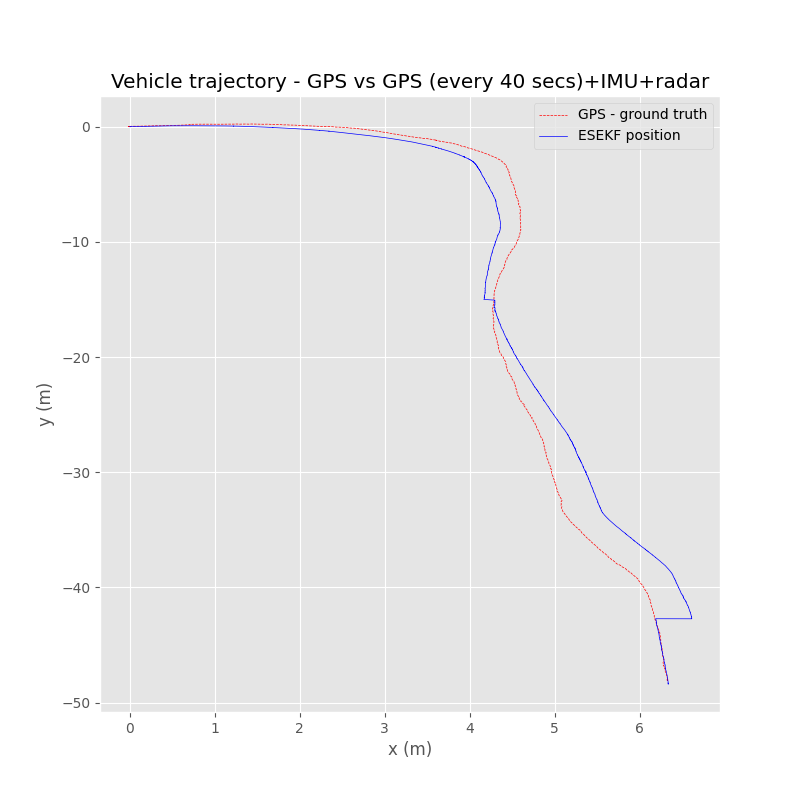

In [20]:
vis_traj_2d(x_list, p_gps)

In [19]:
# vis_traj_3d(x_list, p_gps)